### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by='fpr').reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    return train_data, test_data, val_data


## Data1: NN

In [5]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

### Lightning module

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

# A simple classifier head
class SimpleClassifier(nn.Module):
    def __init__(self, input_features=2, hidden_units=32, num_classes=1):
        """
        Args:
            input_features (int): Number of input features (2 for your data)
            hidden_units (int): Number of neurons in the hidden layer
            num_classes (int): Number of output classes (1 for binary)
        """
        super().__init__()
        self.layer_stack = nn.Sequential(
            # --- Hidden Layer 1 ---
            # Takes 2 features in, outputs a hidden representation of size 32
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),  # <-- The crucial non-linear activation function

            # --- Output Layer ---
            # Takes the 16-unit hidden representation, outputs 1 logit
            nn.Linear(in_features=hidden_units, out_features=num_classes)
        )

    def forward(self, x):
        return self.layer_stack(x)

# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=512, hidden_units=32, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = SimpleClassifier(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)


### Generate data

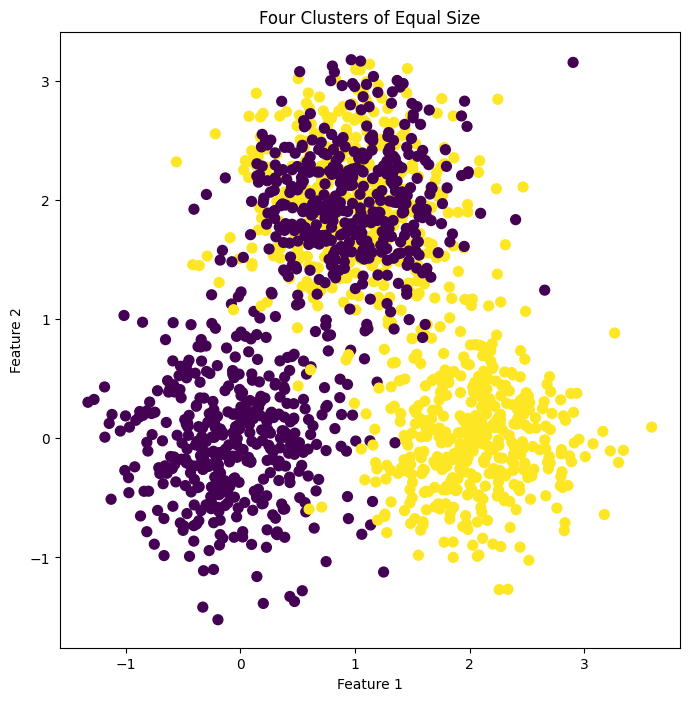

Training data shape: (1000, 2), (1000,)
Test data shape: (600, 2), (600,)


In [8]:
from sklearn.model_selection import KFold

train_data, test_data, val_data = generate_data("data2")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)


### Regular training

In [9]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='simple-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="simple-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 60.02it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 16/16 [00:00<00:00, 58.62it/s, v_num=16]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v15.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v15.ckpt



Best model from Phase 1 saved to: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v15.ckpt

--- Testing model from Phase 1 checkpoint: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/simple-clf-epoch=00-v15.ckpt ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 241.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.6139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 105.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873144507408142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on 

### Oversampling ROC curve

In [10]:
import numpy as np
from collections import Counter
# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed

# --- This block generates the list of ratios for your experiment ---
def generate_ratios(train_data):
    # 1. Get original class counts from your train_dataset

    # --- Initial Data Analysis ---
    counter = Counter(train_data[:, -1])  # Assuming the last column is the class label
    Class0_initial = counter.get(0, 0)
    Class1_initial = counter.get(1, 0)


    class_ratio_low = 0.1   
    class_ratio_high = 100.0 
    num_points_below = 100 
    num_points_above = 100 

    if Class1_initial == 0 and Class0_initial == 0:
        print("ERROR: Both classes have zero samples initially. Cannot proceed.")
        alpha_target_actual_values = [] 
        current_class_ratio = 1.0
    elif Class1_initial == 0:
        current_class_ratio = np.inf 
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # ... (alpha_target_actual_values generation - same robust version) ...
    alpha_target_list = []
    if Class0_initial > 0 or Class1_initial > 0: 
        if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
            alpha_target_list.append(current_class_ratio)
        _safe_class_ratio_low = max(class_ratio_low, EPSILON)
        if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
            try:
                alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
                alpha_target_list.extend(alpha_b)
            except ValueError: pass
        if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
            try:
                _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
                if class_ratio_high > _start_geom_above:
                    alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                    if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                        alpha_target_list.append(current_class_ratio)
                    alpha_target_list.extend(alpha_a)
                elif np.isclose(class_ratio_high, _start_geom_above):
                    alpha_target_list.append(class_ratio_high)
            except ValueError: pass
        if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
            if not np.isinf(current_class_ratio) and current_class_ratio > 0:
                alpha_target_list.append(current_class_ratio)
            else: 
                alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
        alpha_target_actual_values = np.unique(alpha_target_list)
        alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
        alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
        if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
            if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
                alpha_target_actual_values = np.array([current_class_ratio])
            else: 
                alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


    print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
    print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
    print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

    return alpha_target_actual_values, Class0_initial, Class1_initial

In [11]:
import numpy as np
from collections import Counter


def oversample_dataset_KDE(Class0_initial, Class1_initial, alpha_target, train_data):
    """
    Oversamples a dataset to a target ratio using a KDE-like method.
    This version contains fixes for shape errors when no samples are generated.
    """
    # --- Determine Oversampling Strategy ---
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1

    if Class1_initial == 0 and Class0_initial > 0:
        current_class_ratio = np.inf
    elif Class1_initial == 0 and Class0_initial == 0:
        current_class_ratio = 1.0 # Or some other neutral value
    else:
        current_class_ratio = Class0_initial / Class1_initial

    # Decide which class to oversample or if we should do nothing
    if abs(alpha_target - current_class_ratio) < EPSILON:
        # Ratios are the same, do nothing
        initial_count_of_oversampled_class = Class1_initial # Placeholder
        final_count_of_oversampled_class = Class1_initial   # Placeholder
    elif alpha_target > current_class_ratio:
        # Target has more C0 relative to C1 -> Oversample C0
        oversampled_class_label_by_strategy = 0
        initial_count_of_oversampled_class = Class0_initial
        final_count_of_oversampled_class = int(round(Class1_initial * alpha_target))
    else: # alpha_target < current_class_ratio
        # Target has more C1 relative to C0 -> Oversample C1
        oversampled_class_label_by_strategy = 1
        initial_count_of_oversampled_class = Class1_initial
        final_count_of_oversampled_class = int(round(Class0_initial / alpha_target))

    num_synthetic_to_generate = max(0, final_count_of_oversampled_class - initial_count_of_oversampled_class)
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")


    # --- KDE-like Synthetic Sample Generation ---
    if num_synthetic_to_generate > 0:
        print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
        X_new_synthetic = []
        y_new_synthetic = []

        indices_class = np.where(train_data[:, -1] == oversampled_class_label_by_strategy)[0]
        
        if len(indices_class) > 0:
            for _ in range(num_synthetic_to_generate):
                idx_star = np.random.choice(indices_class)
                X_star = train_data[idx_star, :-1]
                epsilon_noise = np.random.randn(*X_star.shape)
                X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
                X_new_synthetic.append(X_prime)
                y_new_synthetic.append(oversampled_class_label_by_strategy)

            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((train_data[:, :-1], X_new_synthetic_arr))
            y_resampled = np.concatenate((train_data[:, -1], y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")
        else:
             # This can happen if the class to oversample has 0 members
            print("  WARNING: Cannot generate samples for a class with 0 members. Returning original data.")
            X_resampled = train_data[:, :-1]
            y_resampled = train_data[:, -1]

    else: # num_synthetic_to_generate is 0
        print("  INFO: No synthetic samples were required or generated.")
        # --- THIS IS THE CRITICAL FIX ---
        # Correctly slice the original data instead of copying the whole array
        X_resampled = train_data[:, :-1]
        y_resampled = train_data[:, -1]
        # ----------------------------

    return X_resampled, y_resampled

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)
    alpha_target_actual_values, Class0_initial, Class1_initial  = generate_ratios(train_data=train_data)  # Combine features and labels for ratio generation


    for w_idx, w in enumerate(alpha_target_actual_values):
        print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")
        X_train, y_train = oversample_dataset_KDE(Class0_initial, Class1_initial, w, train_data)
        # 1. Instantiate the LightningModule
        model = LitClassifier(input_features=2, hidden_units=32, learning_rate=LEARNING_RATE)
        
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{w_idx+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            #logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{w_idx+1}_fold_{fold+1}_ratio_{alpha_target_actual_values}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {w_idx+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {w_idx+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {w_idx+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.0

--- Starting Fold 1/4 ---
INFO: Initial C0=500, C1=500, Ratio(0/1): 1.0
INFO: Target ratios (w values): [  0.1          0.1023293    0.10471285   0.10715193   0.10964782
   0.11220185   0.11481536   0.11748976   0.12022644   0.12302688
   0.12589254   0.12882496   0.13182567   0.13489629   0.13803843
   0.14125375   0.14454398   0.14791084   0.15135612   0.15488166
   0.15848932   0.16218101   0.16595869   0.16982437   0.17378008
   0.17782794   0.18197009   0.18620871   0.19054607   0.19498446
   0.19952623   0.20417379   0.20892961   0.21379621   0.21877616
   0.22387211   0.22908677   0.23442288   0.23988329   0.24547089
   0.25118864   0.25703958   0.2630268    0.26915348   0.27542287
   0.28183829   0.28840315   0.29512092   0.30199517   0.30902954
   0.31622777   0.32359366   0.33113112   0.33884416   0.34673685
   0.35481339   0.36307805   0.37153523   0.3801894    0.38904514
   0.39810717   0.40738028   0.41686938   0.42657952   0.43651583
   0.44668359   0.45708819   0.4677351

/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.54it/s, v_num=5075]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.72it/s, v_num=5075]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5324
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6935874819755554
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (2/200): 0.1023 ---
  INFO: Strategy: Oversample class 1 from 500 to 4886 (generating 4386 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4886


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.64it/s, v_num=5076]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.06it/s, v_num=5076]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3367
AUC: 0.2818
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7320709228515625
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (3/200): 0.1047 ---
  INFO: Strategy: Oversample class 1 from 500 to 4775 (generating 4275 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4775


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.79it/s, v_num=5077]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.12it/s, v_num=5077]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.7972
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6611687541007996
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (4/200): 0.1072 ---
  INFO: Strategy: Oversample class 1 from 500 to 4666 (generating 4166 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4666


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.52it/s, v_num=5078]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.19it/s, v_num=5078]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3167
AUC: 0.3323
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7174733281135559
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (5/200): 0.1096 ---
  INFO: Strategy: Oversample class 1 from 500 to 4560 (generating 4060 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4560


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.96it/s, v_num=5079]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.67it/s, v_num=5079]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 533.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.5724
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6855311393737793
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=500, C1=4456


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.87it/s, v_num=5080]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.25it/s, v_num=5080]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.7260
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6187953948974609
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=500, C1=4355


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.28it/s, v_num=5081]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.42it/s, v_num=5081]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.5952
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6909157633781433
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (8/200): 0.1175 ---
  INFO: Strategy: Oversample class 1 from 500 to 4256 (generating 3756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.79it/s, v_num=5082]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.93it/s, v_num=5082]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3067
AUC: 0.3249
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7324007749557495
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (9/200): 0.1202 ---
  INFO: Strategy: Oversample class 1 from 500 to 4159 (generating 3659 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4159


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.20it/s, v_num=5083]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.13it/s, v_num=5083]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.5862
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6876469254493713
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (10/200): 0.1230 ---
  INFO: Strategy: Oversample class 1 from 500 to 4064 (generating 3564 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4064


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.04it/s, v_num=5084]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.72it/s, v_num=5084]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7736
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6980063915252686
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (11/200): 0.1259 ---
  INFO: Strategy: Oversample class 1 from 500 to 3972 (generating 3472 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3972



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.33it/s, v_num=5085]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.15it/s, v_num=5085]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6709
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6802952885627747
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (12/200): 0.1288 ---
  INFO: Strategy: Oversample class 1 from 500 to 3881 (generating 3381 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3881


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.08it/s, v_num=5086]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.92it/s, v_num=5086]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v14.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v14.ckpt



--- Fold 1 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v14.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v14.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3878
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004754543304443
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (13/200): 0.1318 ---
  INFO: Strategy: Oversample class 1 from 500 to 3793 (generating 3293 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3793



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.07it/s, v_num=5087]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.63it/s, v_num=5087]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 437.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.8132
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6642037034034729
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

  INFO: KDE-like generation complete. New C0=500, C1=3707
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.50it/s, v_num=5088]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.64it/s, v_num=5088]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4383
AUC: 0.3926
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167729139328003
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (15/200): 0.1380 ---
  INFO: Strategy: Oversample class 1 from 500 to 3622 (generating 3122 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3622


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.82it/s, v_num=5089]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.45it/s, v_num=5089]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 516.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6272
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7211912274360657
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (16/200): 0.1413 ---
  INFO: Strategy: Oversample class 1 from 500 to 3540 (generating 3040 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3540


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.38it/s, v_num=5090]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.43it/s, v_num=5090]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.5418
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921325922012329
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (17/200): 0.1445 ---
  INFO: Strategy: Oversample class 1 from 500 to 3459 (generating 2959 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3459


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.31it/s, v_num=5091]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.52it/s, v_num=5091]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8495
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667738556861877
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (18/200): 0.1479 ---
  INFO: Strategy: Oversample class 1 from 500 to 3380 (generating 2880 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3380


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.93it/s, v_num=5092]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.63it/s, v_num=5092]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.4083
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7023031115531921
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (19/200): 0.1514 ---
  INFO: Strategy: Oversample class 1 from 500 to 3303 (generating 2803 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3303


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.33it/s, v_num=5093]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.18it/s, v_num=5093]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.4576
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7265557646751404
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (20/200): 0.1549 ---
  INFO: Strategy: Oversample class 1 from 500 to 3228 (generating 2728 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3228
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.99it/s, v_num=5094]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.35it/s, v_num=5094]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3767
AUC: 0.3933
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004746198654175
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (21/200): 0.1585 ---
  INFO: Strategy: Oversample class 1 from 500 to 3155 (generating 2655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3155
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.43it/s, v_num=5095]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.88it/s, v_num=5095]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.7344
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6686084270477295
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (22/200): 0.1622 ---
  INFO: Strategy: Oversample class 1 from 500 to 3083 (generating 2583 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3083
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.44it/s, v_num=5096]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.22it/s, v_num=5096]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.6207
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6672404408454895
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (23/200): 0.1660 ---
  INFO: Strategy: Oversample class 1 from 500 to 3013 (generating 2513 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3013
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.29it/s, v_num=5097]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.97it/s, v_num=5097]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.8360
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6192159056663513
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (24/200): 0.1698 ---
  INFO: Strategy: Oversample class 1 from 500 to 2944 (generating 2444 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2944


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.85it/s, v_num=5098]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.89it/s, v_num=5098]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5349
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6975312232971191
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (25/200): 0.1738 ---
  INFO: Strategy: Oversample class 1 from 500 to 2877 (generating 2377 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2877



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.36it/s, v_num=5099]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.35it/s, v_num=5099]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4117
AUC: 0.4323
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7186456918716431
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (26/200): 0.1778 ---
  INFO: Strategy: Oversample class 1 from 500 to 2812 (generating 2312 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2812


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.67it/s, v_num=5100]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.16it/s, v_num=5100]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.8321
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.645618200302124
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e

  INFO: KDE-like generation complete. New C0=500, C1=2748
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.61it/s, v_num=5101]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.41it/s, v_num=5101]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2897
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7433796525001526
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (28/200): 0.1862 ---
  INFO: Strategy: Oversample class 1 from 500 to 2685 (generating 2185 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2685
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.30it/s, v_num=5102]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.27it/s, v_num=5102]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.6501
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683708429336548
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (29/200): 0.1905 ---
  INFO: Strategy: Oversample class 1 from 500 to 2624 (generating 2124 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2624


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.26it/s, v_num=5103]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.93it/s, v_num=5103]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.6144
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6606033444404602
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (30/200): 0.1950 ---
  INFO: Strategy: Oversample class 1 from 500 to 2564 (generating 2064 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2564


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.57it/s, v_num=5104]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.10it/s, v_num=5104]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6678
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822472810745239
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (31/200): 0.1995 ---
  INFO: Strategy: Oversample class 1 from 500 to 2506 (generating 2006 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2506
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.04it/s, v_num=5105]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.69it/s, v_num=5105]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6333
AUC: 0.6420
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6643736362457275
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (32/200): 0.2042 ---
  INFO: Strategy: Oversample class 1 from 500 to 2449 (generating 1949 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2449


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.56it/s, v_num=5106]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.81it/s, v_num=5106]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6479015350341797
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (33/200): 0.2089 ---
  INFO: Strategy: Oversample class 1 from 500 to 2393 (generating 1893 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2393
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.80it/s, v_num=5107]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.08it/s, v_num=5107]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5257
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203903198242188
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (34/200): 0.2138 ---
  INFO: Strategy: Oversample class 1 from 500 to 2339 (generating 1839 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2339
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.21it/s, v_num=5108]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.72it/s, v_num=5108]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 453.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6100
AUC: 0.5892
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6786776781082153
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (35/200): 0.2188 ---
  INFO: Strategy: Oversample class 1 from 500 to 2285 (generating 1785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2285
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.01it/s, v_num=5109]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.66it/s, v_num=5109]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 493.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.6442
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6775423288345337
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (36/200): 0.2239 ---
  INFO: Strategy: Oversample class 1 from 500 to 2233 (generating 1733 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2233
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.21it/s, v_num=5110]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.75it/s, v_num=5110]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4235
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7645981907844543
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (37/200): 0.2291 ---
  INFO: Strategy: Oversample class 1 from 500 to 2183 (generating 1683 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2183
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 158.68it/s, v_num=5111]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.48it/s, v_num=5111]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.8083
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6592474579811096
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (38/200): 0.2344 ---
  INFO: Strategy: Oversample class 1 from 500 to 2133 (generating 1633 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2133
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.95it/s, v_num=5112]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.42it/s, v_num=5112]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3133
AUC: 0.2626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7227150797843933
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (39/200): 0.2399 ---
  INFO: Strategy: Oversample class 1 from 500 to 2084 (generating 1584 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2084
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.24it/s, v_num=5113]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.59it/s, v_num=5113]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7120358347892761
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (40/200): 0.2455 ---
  INFO: Strategy: Oversample class 1 from 500 to 2037 (generating 1537 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2037
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.68it/s, v_num=5114]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.51it/s, v_num=5114]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6533
AUC: 0.5810
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6756995320320129
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (41/200): 0.2512 ---
  INFO: Strategy: Oversample class 1 from 500 to 1991 (generating 1491 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1991
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.35it/s, v_num=5115]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.85it/s, v_num=5115]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.3654
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468218803405762
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (42/200): 0.2570 ---
  INFO: Strategy: Oversample class 1 from 500 to 1945 (generating 1445 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1945


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.36it/s, v_num=5116]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.53it/s, v_num=5116]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.6225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6583920121192932
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (43/200): 0.2630 ---
  INFO: Strategy: Oversample class 1 from 500 to 1901 (generating 1401 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1901


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.92it/s, v_num=5117]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.03it/s, v_num=5117]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931405663490295
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (44/200): 0.2692 ---
  INFO: Strategy: Oversample class 1 from 500 to 1858 (generating 1358 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1858
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.45it/s, v_num=5118]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.33it/s, v_num=5118]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.7583
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6735368967056274
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (45/200): 0.2754 ---
  INFO: Strategy: Oversample class 1 from 500 to 1815 (generating 1315 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1815
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.47it/s, v_num=5119]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.55it/s, v_num=5119]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5867
AUC: 0.6283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6633777618408203
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (46/200): 0.2818 ---
  INFO: Strategy: Oversample class 1 from 500 to 1774 (generating 1274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1774
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.21it/s, v_num=5120]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.73it/s, v_num=5120]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.6979
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6532946825027466
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (47/200): 0.2884 ---
  INFO: Strategy: Oversample class 1 from 500 to 1734 (generating 1234 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1734
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.74it/s, v_num=5121]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.72it/s, v_num=5121]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.6116
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6621900200843811
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (48/200): 0.2951 ---
  INFO: Strategy: Oversample class 1 from 500 to 1694 (generating 1194 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1694


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.74it/s, v_num=5122]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.90it/s, v_num=5122]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 440.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6839
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6755555272102356
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (49/200): 0.3020 ---
  INFO: Strategy: Oversample class 1 from 500 to 1656 (generating 1156 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1656
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.64it/s, v_num=5123]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.52it/s, v_num=5123]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 453.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7640
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676030158996582
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (50/200): 0.3090 ---
  INFO: Strategy: Oversample class 1 from 500 to 1618 (generating 1118 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1618
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.46it/s, v_num=5124]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.37it/s, v_num=5124]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v13.ckpt



--- Fold 1 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4732
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7036524415016174
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (51/200): 0.3162 ---
  INFO: Strategy: Oversample class 1 from 500 to 1581 (generating 1081 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1581



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.53it/s, v_num=5125]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.05it/s, v_num=5125]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt



--- Fold 1 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.7480
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6558300852775574
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (52/200): 0.3236 ---
  INFO: Strategy: Oversample class 1 from 500 to 1545 (generating 1045 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1545
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.97it/s, v_num=5126]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.38it/s, v_num=5126]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 52 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 431.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.5280
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.69434654712677
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (53/200): 0.3311 ---
  INFO: Strategy: Oversample class 1 from 500 to 1510 (generating 1010 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1510
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.97it/s, v_num=5127]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.01it/s, v_num=5127]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 53 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 545.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3133
AUC: 0.2575
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7993985414505005
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (54/200): 0.3388 ---
  INFO: Strategy: Oversample class 1 from 500 to 1476 (generating 976 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1476
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.37it/s, v_num=5128]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.62it/s, v_num=5128]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 54 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4233
AUC: 0.1576
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7420099377632141
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (55/200): 0.3467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1442 (generating 942 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1442



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.87it/s, v_num=5129]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.77it/s, v_num=5129]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 55 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3830
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7334274053573608
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (56/200): 0.3548 ---
  INFO: Strategy: Oversample class 1 from 500 to 1409 (generating 909 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1409
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.11it/s, v_num=5130]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.57it/s, v_num=5130]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 56 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.3738
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.71968674659729
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (57/200): 0.3631 ---
  INFO: Strategy: Oversample class 1 from 500 to 1377 (generating 877 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1377
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.26it/s, v_num=5131]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.75it/s, v_num=5131]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 57 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.4208
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6999582648277283
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (58/200): 0.3715 ---
  INFO: Strategy: Oversample class 1 from 500 to 1346 (generating 846 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1346
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.95it/s, v_num=5132]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.25it/s, v_num=5132]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 58 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2684
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7247018218040466
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (59/200): 0.3802 ---
  INFO: Strategy: Oversample class 1 from 500 to 1315 (generating 815 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1315
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.94it/s, v_num=5133]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.29it/s, v_num=5133]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 59 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 432.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2967
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7091780304908752
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (60/200): 0.3890 ---
  INFO: Strategy: Oversample class 1 from 500 to 1285 (generating 785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1285
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.05it/s, v_num=5134]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.12it/s, v_num=5134]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 60 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3383
AUC: 0.2822
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7239353656768799
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (61/200): 0.3981 ---
  INFO: Strategy: Oversample class 1 from 500 to 1256 (generating 756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1256
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.91it/s, v_num=5135]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.74it/s, v_num=5135]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 61 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 256.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.6053
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 212.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7122623324394226
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (62/200): 0.4074 ---
  INFO: Strategy: Oversample class 1 from 500 to 1227 (generating 727 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1227


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.02it/s, v_num=5136]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.37it/s, v_num=5136]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 62 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4183
AUC: 0.4345
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7187982797622681
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (63/200): 0.4169 ---
  INFO: Strategy: Oversample class 1 from 500 to 1199 (generating 699 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1199
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.97it/s, v_num=5137]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.14it/s, v_num=5137]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 63 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.4146
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7151056528091431
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (64/200): 0.4266 ---
  INFO: Strategy: Oversample class 1 from 500 to 1172 (generating 672 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1172
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.50it/s, v_num=5138]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.59it/s, v_num=5138]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 64 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4667
AUC: 0.4126
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7156555652618408
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (65/200): 0.4365 ---
  INFO: Strategy: Oversample class 1 from 500 to 1145 (generating 645 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1145
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.02it/s, v_num=5139]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.61it/s, v_num=5139]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 65 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4250
AUC: 0.4472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7061038017272949
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (66/200): 0.4467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1119 (generating 619 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1119
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.11it/s, v_num=5140]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.70it/s, v_num=5140]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 66 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.7824
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6578089594841003
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (67/200): 0.4571 ---
  INFO: Strategy: Oversample class 1 from 500 to 1094 (generating 594 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1094
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.69it/s, v_num=5141]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.03it/s, v_num=5141]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 67 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.8057
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6814960241317749
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (68/200): 0.4677 ---
  INFO: Strategy: Oversample class 1 from 500 to 1069 (generating 569 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1069
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.01it/s, v_num=5142]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.79it/s, v_num=5142]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 68 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.7203
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6872333884239197
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (69/200): 0.4786 ---
  INFO: Strategy: Oversample class 1 from 500 to 1045 (generating 545 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1045
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.77it/s, v_num=5143]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.25it/s, v_num=5143]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 69 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.6625
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901033520698547
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (70/200): 0.4898 ---
  INFO: Strategy: Oversample class 1 from 500 to 1021 (generating 521 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1021


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.84it/s, v_num=5144]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.51it/s, v_num=5144]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 70 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.3387
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.714139997959137
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (71/200): 0.5012 ---
  INFO: Strategy: Oversample class 1 from 500 to 998 (generating 498 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=998
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.58it/s, v_num=5145]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.08it/s, v_num=5145]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 71 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6650
AUC: 0.7749
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.66249018907547
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (72/200): 0.5129 ---
  INFO: Strategy: Oversample class 1 from 500 to 975 (generating 475 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=975
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.97it/s, v_num=5146]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.65it/s, v_num=5146]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 72 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2312
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7705199122428894
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (73/200): 0.5248 ---
  INFO: Strategy: Oversample class 1 from 500 to 953 (generating 453 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=953
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.31it/s, v_num=5147]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.71it/s, v_num=5147]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 73 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.7387
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6547378301620483
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (74/200): 0.5370 ---
  INFO: Strategy: Oversample class 1 from 500 to 931 (generating 431 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=931


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.71it/s, v_num=5148]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.55it/s, v_num=5148]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 74 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.5668
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.683360755443573
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (75/200): 0.5495 ---
  INFO: Strategy: Oversample class 1 from 500 to 910 (generating 410 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=910
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.60it/s, v_num=5149]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.91it/s, v_num=5149]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 75 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.5468
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7017324566841125
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (76/200): 0.5623 ---
  INFO: Strategy: Oversample class 1 from 500 to 889 (generating 389 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=889
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.10it/s, v_num=5150]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.12it/s, v_num=5150]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 76 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4704
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7336421012878418
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (77/200): 0.5754 ---
  INFO: Strategy: Oversample class 1 from 500 to 869 (generating 369 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=869
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.29it/s, v_num=5151]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.59it/s, v_num=5151]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 77 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6933
AUC: 0.6844
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6413359642028809
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (78/200): 0.5888 ---
  INFO: Strategy: Oversample class 1 from 500 to 849 (generating 349 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=849


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.68it/s, v_num=5152]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.01it/s, v_num=5152]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 78 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5667
AUC: 0.6661
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6763719320297241
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (79/200): 0.6026 ---
  INFO: Strategy: Oversample class 1 from 500 to 830 (generating 330 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=830
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.41it/s, v_num=5153]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.10it/s, v_num=5153]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 79 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6333
AUC: 0.6473
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6606412529945374
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (80/200): 0.6166 ---
  INFO: Strategy: Oversample class 1 from 500 to 811 (generating 311 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=811
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.15it/s, v_num=5154]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.20it/s, v_num=5154]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 80 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.1703
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7543500661849976
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (81/200): 0.6310 ---
  INFO: Strategy: Oversample class 1 from 500 to 792 (generating 292 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=792



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.54it/s, v_num=5155]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.52it/s, v_num=5155]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 81 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.4897
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7004129886627197
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (82/200): 0.6457 ---
  INFO: Strategy: Oversample class 1 from 500 to 774 (generating 274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=774
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.10it/s, v_num=5156]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.55it/s, v_num=5156]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 82 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7462
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.667347252368927
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (83/200): 0.6607 ---
  INFO: Strategy: Oversample class 1 from 500 to 757 (generating 257 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=757


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.41it/s, v_num=5157]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.01it/s, v_num=5157]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 83 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.6341
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6691848039627075
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (84/200): 0.6761 ---
  INFO: Strategy: Oversample class 1 from 500 to 740 (generating 240 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=740


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.94it/s, v_num=5158]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.01it/s, v_num=5158]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 84 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.7732
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6773104667663574
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (85/200): 0.6918 ---
  INFO: Strategy: Oversample class 1 from 500 to 723 (generating 223 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=723


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.28it/s, v_num=5159]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.65it/s, v_num=5159]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 85 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.6255
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6672583222389221
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (86/200): 0.7079 ---
  INFO: Strategy: Oversample class 1 from 500 to 706 (generating 206 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=706


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.81it/s, v_num=5160]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.40it/s, v_num=5160]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 86 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.5888
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.68682861328125
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (87/200): 0.7244 ---
  INFO: Strategy: Oversample class 1 from 500 to 690 (generating 190 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=690
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.45it/s, v_num=5161]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.74it/s, v_num=5161]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 87 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7464
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.49it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6772854924201965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (88/200): 0.7413 ---
  INFO: Strategy: Oversample class 1 from 500 to 674 (generating 174 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=674


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.23it/s, v_num=5162]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.63it/s, v_num=5162]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 88 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.8456
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.31it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6574490070343018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (89/200): 0.7586 ---
  INFO: Strategy: Oversample class 1 from 500 to 659 (generating 159 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=659


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.53it/s, v_num=5163]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.08it/s, v_num=5163]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 89 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.7448
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 244.58it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683254241943359
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (90/200): 0.7762 ---
  INFO: Strategy: Oversample class 1 from 500 to 644 (generating 144 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=644


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.04it/s, v_num=5164]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.80it/s, v_num=5164]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 90 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3367
AUC: 0.3951
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7149986028671265
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (91/200): 0.7943 ---
  INFO: Strategy: Oversample class 1 from 500 to 629 (generating 129 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=629
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.56it/s, v_num=5165]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.28it/s, v_num=5165]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 91 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.4588
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7018052935600281
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (92/200): 0.8128 ---
  INFO: Strategy: Oversample class 1 from 500 to 615 (generating 115 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=615
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.19it/s, v_num=5166]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.85it/s, v_num=5166]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 92 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5417
AUC: 0.5390
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7249462008476257
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (93/200): 0.8318 ---
  INFO: Strategy: Oversample class 1 from 500 to 601 (generating 101 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=601


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.24it/s, v_num=5167]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.06it/s, v_num=5167]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 93 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3280
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7220063209533691
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (94/200): 0.8511 ---
  INFO: Strategy: Oversample class 1 from 500 to 587 (generating 87 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=587


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.27it/s, v_num=5168]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.95it/s, v_num=5168]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 94 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.7862
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665542721748352
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (95/200): 0.8710 ---
  INFO: Strategy: Oversample class 1 from 500 to 574 (generating 74 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=574
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.13it/s, v_num=5169]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.86it/s, v_num=5169]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 95 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.7418
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6810963153839111
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (96/200): 0.8913 ---
  INFO: Strategy: Oversample class 1 from 500 to 561 (generating 61 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=561


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.55it/s, v_num=5170]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.68it/s, v_num=5170]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 96 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.3267
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7073594927787781
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (97/200): 0.9120 ---
  INFO: Strategy: Oversample class 1 from 500 to 548 (generating 48 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=548


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.13it/s, v_num=5171]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.94it/s, v_num=5171]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 97 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 543.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7953
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6149966716766357
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (98/200): 0.9333 ---
  INFO: Strategy: Oversample class 1 from 500 to 536 (generating 36 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=536



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.07it/s, v_num=5172]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.11it/s, v_num=5172]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 98 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7186
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.671888530254364
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (99/200): 0.9550 ---
  INFO: Strategy: Oversample class 1 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=524


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.39it/s, v_num=5173]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.19it/s, v_num=5173]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 99 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 457.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.4922
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7082425951957703
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (100/200): 0.9772 ---
  INFO: Strategy: Oversample class 1 from 500 to 512 (generating 12 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=512
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.93it/s, v_num=5174]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.61it/s, v_num=5174]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 100 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.6978
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             0.6763955950737
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (101/200): 1.0000 ---
  INFO: Strategy: Oversample class -1 from 500 to 500 (generating 0 samples).
  INFO: No synthetic samples were required or generated.


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.16it/s, v_num=5175]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.17it/s, v_num=5175]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 101 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 101 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 475.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6819
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961557269096375
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (102/200): 1.0476 ---
  INFO: Strategy: Oversample class 0 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=524, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.44it/s, v_num=5176]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.54it/s, v_num=5176]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 102 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 102 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5767
AUC: 0.5664
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833784580230713
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (103/200): 1.0975 ---
  INFO: Strategy: Oversample class 0 from 500 to 549 (generating 49 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=549, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.26it/s, v_num=5177]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.59it/s, v_num=5177]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 103 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 103 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.6714
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6689279079437256
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (104/200): 1.1498 ---
  INFO: Strategy: Oversample class 0 from 500 to 575 (generating 75 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=575, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.35it/s, v_num=5178]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.42it/s, v_num=5178]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 104 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 104 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4533
AUC: 0.3396
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7219475507736206
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (105/200): 1.2045 ---
  INFO: Strategy: Oversample class 0 from 500 to 602 (generating 102 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=602, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.59it/s, v_num=5179]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.34it/s, v_num=5179]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 105 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 105 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6200
AUC: 0.6326
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785711646080017
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (106/200): 1.2619 ---
  INFO: Strategy: Oversample class 0 from 500 to 631 (generating 131 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=631, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.85it/s, v_num=5180]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.98it/s, v_num=5180]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 106 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 106 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.8404
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6550267934799194
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (107/200): 1.3219 ---
  INFO: Strategy: Oversample class 0 from 500 to 661 (generating 161 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=661, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.70it/s, v_num=5181]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.97it/s, v_num=5181]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 107 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 107 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.6790
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6702931523323059
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (108/200): 1.3849 ---
  INFO: Strategy: Oversample class 0 from 500 to 692 (generating 192 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=692, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.85it/s, v_num=5182]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.76it/s, v_num=5182]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 108 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 108 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.2363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7985064387321472
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (109/200): 1.4508 ---
  INFO: Strategy: Oversample class 0 from 500 to 725 (generating 225 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=725, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.39it/s, v_num=5183]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.89it/s, v_num=5183]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 109 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 109 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 468.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.7876
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.664209246635437
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (110/200): 1.5199 ---
  INFO: Strategy: Oversample class 0 from 500 to 760 (generating 260 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=760, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.99it/s, v_num=5184]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.71it/s, v_num=5184]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 110 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 110 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4925
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6955950856208801
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (111/200): 1.5923 ---
  INFO: Strategy: Oversample class 0 from 500 to 796 (generating 296 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=796, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.05it/s, v_num=5185]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.98it/s, v_num=5185]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 111 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 111 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7167
AUC: 0.8309
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6292471885681152
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (112/200): 1.6681 ---
  INFO: Strategy: Oversample class 0 from 500 to 834 (generating 334 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=834, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.14it/s, v_num=5186]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.18it/s, v_num=5186]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 112 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 112 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6334
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6538419127464294
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (113/200): 1.7475 ---
  INFO: Strategy: Oversample class 0 from 500 to 874 (generating 374 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=874, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.41it/s, v_num=5187]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.42it/s, v_num=5187]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 113 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 113 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.2716
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7470765113830566
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (114/200): 1.8307 ---
  INFO: Strategy: Oversample class 0 from 500 to 915 (generating 415 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=915, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.79it/s, v_num=5188]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.65it/s, v_num=5188]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 114 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 114 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.7026
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6486997604370117
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (115/200): 1.9179 ---
  INFO: Strategy: Oversample class 0 from 500 to 959 (generating 459 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=959, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.53it/s, v_num=5189]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.32it/s, v_num=5189]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 115 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 115 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.2612
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7372740507125854
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (116/200): 2.0092 ---
  INFO: Strategy: Oversample class 0 from 500 to 1005 (generating 505 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1005, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.18it/s, v_num=5190]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.46it/s, v_num=5190]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 116 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 116 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7549
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6529533267021179
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (117/200): 2.1049 ---
  INFO: Strategy: Oversample class 0 from 500 to 1052 (generating 552 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1052, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.33it/s, v_num=5191]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.97it/s, v_num=5191]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 117 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 117 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.8193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.76it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6394339203834534
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (118/200): 2.2051 ---
  INFO: Strategy: Oversample class 0 from 500 to 1103 (generating 603 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1103, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.44it/s, v_num=5192]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.92it/s, v_num=5192]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 118 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 118 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7267
AUC: 0.6799
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6336848139762878
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (119/200): 2.3101 ---
  INFO: Strategy: Oversample class 0 from 500 to 1155 (generating 655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1155, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.43it/s, v_num=5193]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.91it/s, v_num=5193]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 119 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 119 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6538
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6956055760383606
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (120/200): 2.4201 ---
  INFO: Strategy: Oversample class 0 from 500 to 1210 (generating 710 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1210, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.50it/s, v_num=5194]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.62it/s, v_num=5194]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 120 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 120 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.8293
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6522274017333984
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (121/200): 2.5354 ---
  INFO: Strategy: Oversample class 0 from 500 to 1268 (generating 768 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1268, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.22it/s, v_num=5195]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=5195]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 121 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 121 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.7867
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6259368658065796
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (122/200): 2.6561 ---
  INFO: Strategy: Oversample class 0 from 500 to 1328 (generating 828 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1328, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.07it/s, v_num=5196]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.01it/s, v_num=5196]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 122 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 122 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4483
AUC: 0.4157
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7226264476776123
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (123/200): 2.7826 ---
  INFO: Strategy: Oversample class 0 from 500 to 1391 (generating 891 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1391, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.83it/s, v_num=5197]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.30it/s, v_num=5197]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 123 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 123 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5183
AUC: 0.4697
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6948673725128174
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (124/200): 2.9151 ---
  INFO: Strategy: Oversample class 0 from 500 to 1458 (generating 958 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1458, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.61it/s, v_num=5198]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.49it/s, v_num=5198]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 124 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 124 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7350
AUC: 0.7969
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6386520266532898
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (125/200): 3.0539 ---
  INFO: Strategy: Oversample class 0 from 500 to 1527 (generating 1027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1527, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.07it/s, v_num=5199]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.71it/s, v_num=5199]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 125 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 125 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6709
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6904435157775879
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (126/200): 3.1993 ---
  INFO: Strategy: Oversample class 0 from 500 to 1600 (generating 1100 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1600, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.18it/s, v_num=5200]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.59it/s, v_num=5200]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 126 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 126 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 459.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6829
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6645392775535583
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (127/200): 3.3516 ---
  INFO: Strategy: Oversample class 0 from 500 to 1676 (generating 1176 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1676, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.93it/s, v_num=5201]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.91it/s, v_num=5201]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 127 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 127 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7760
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6776714324951172
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (128/200): 3.5112 ---
  INFO: Strategy: Oversample class 0 from 500 to 1756 (generating 1256 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1756, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.54it/s, v_num=5202]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.49it/s, v_num=5202]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 1 Stage 128 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 128 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_1/best-model-fold1-epoch=00-v7.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.7736
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 220.24it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6394730806350708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (129/200): 3.6784 ---
  INFO: Strategy: Oversample class 0 from 500 to 1839 (generating 1339 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1839, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.90it/s, v_num=5203]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.40it/s, v_num=5203]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 129 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 129 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6383
AUC: 0.6304
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6774075627326965
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (130/200): 3.8535 ---
  INFO: Strategy: Oversample class 0 from 500 to 1927 (generating 1427 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1927, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.26it/s, v_num=5204]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.01it/s, v_num=5204]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 130 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 130 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.4973
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7104306817054749
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (131/200): 4.0370 ---
  INFO: Strategy: Oversample class 0 from 500 to 2019 (generating 1519 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2019, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.45it/s, v_num=5205]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.40it/s, v_num=5205]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 131 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 131 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4250
AUC: 0.4237
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7496349811553955
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (132/200): 4.2292 ---
  INFO: Strategy: Oversample class 0 from 500 to 2115 (generating 1615 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2115, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.82it/s, v_num=5206]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.39it/s, v_num=5206]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 132 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 132 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.4865
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7091651558876038
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (133/200): 4.4306 ---
  INFO: Strategy: Oversample class 0 from 500 to 2215 (generating 1715 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2215, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.99it/s, v_num=5207]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.21it/s, v_num=5207]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 133 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 133 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.2472
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7250286340713501
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (134/200): 4.6416 ---
  INFO: Strategy: Oversample class 0 from 500 to 2321 (generating 1821 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2321, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.47it/s, v_num=5208]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.23it/s, v_num=5208]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 134 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 134 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.7264
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.84it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764348149299622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (135/200): 4.8626 ---
  INFO: Strategy: Oversample class 0 from 500 to 2431 (generating 1931 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2431, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.81it/s, v_num=5209]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.04it/s, v_num=5209]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 135 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 135 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.5334
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6917376518249512
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (136/200): 5.0941 ---
  INFO: Strategy: Oversample class 0 from 500 to 2547 (generating 2047 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2547, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.67it/s, v_num=5210]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.73it/s, v_num=5210] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 136 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 136 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_1/best-model-fold1-epoch=00-v7.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6500
AUC: 0.8338
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.72it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6697132587432861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (137/200): 5.3367 ---
  INFO: Strategy: Oversample class 0 from 500 to 2668 (generating 2168 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2668, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.85it/s, v_num=5211]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.55it/s, v_num=5211]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 137 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 137 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.7979
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6574618220329285
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.05it/s, v_num=5212]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.95it/s, v_num=5212]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 138 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 138 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_1/best-model-fold1-epoch=00-v7.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4183
AUC: 0.4366
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.56it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.729187548160553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (139/200): 5.8570 ---
  INFO: Strategy: Oversample class 0 from 500 to 2929 (generating 2429 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2929, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.77it/s, v_num=5213]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.69it/s, v_num=5213]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 139 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 139 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3933
AUC: 0.4223
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7002663016319275
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (140/200): 6.1359 ---
  INFO: Strategy: Oversample class 0 from 500 to 3068 (generating 2568 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3068, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.73it/s, v_num=5214]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.85it/s, v_num=5214]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 140 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 140 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7659
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.62it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6570809483528137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (141/200): 6.4281 ---
  INFO: Strategy: Oversample class 0 from 500 to 3214 (generating 2714 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3214, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.02it/s, v_num=5215]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.04it/s, v_num=5215]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 141 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 141 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.6044
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6799578070640564
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (142/200): 6.7342 ---
  INFO: Strategy: Oversample class 0 from 500 to 3367 (generating 2867 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3367, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.21it/s, v_num=5216]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.88it/s, v_num=5216]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 142 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 142 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2917
AUC: 0.3737
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7546443939208984
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (143/200): 7.0548 ---
  INFO: Strategy: Oversample class 0 from 500 to 3527 (generating 3027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3527, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.85it/s, v_num=5217]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.64it/s, v_num=5217]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 143 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 143 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5095
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.743812084197998
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (144/200): 7.3907 ---
  INFO: Strategy: Oversample class 0 from 500 to 3695 (generating 3195 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3695, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.48it/s, v_num=5218]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.93it/s, v_num=5218]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 144 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 144 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5517
AUC: 0.8045
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6417713761329651
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (145/200): 7.7426 ---
  INFO: Strategy: Oversample class 0 from 500 to 3871 (generating 3371 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3871, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.80it/s, v_num=5219]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.00it/s, v_num=5219]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 145 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 145 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.4170
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7201567888259888
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (146/200): 8.1113 ---
  INFO: Strategy: Oversample class 0 from 500 to 4056 (generating 3556 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4056, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.39it/s, v_num=5220]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.83it/s, v_num=5220]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 146 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 146 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.2483
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7624696493148804
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.77it/s, v_num=5221]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.46it/s, v_num=5221]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 147 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 147 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6949
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6802287697792053
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4451, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.82it/s, v_num=5222]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.26it/s, v_num=5222]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 148 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 148 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6887611150741577
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (149/200): 9.3260 ---
  INFO: Strategy: Oversample class 0 from 500 to 4663 (generating 4163 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4663, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.14it/s, v_num=5223]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.56it/s, v_num=5223]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 149 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 149 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.7189
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 245.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6649472713470459
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=4885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.24it/s, v_num=5224]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.80it/s, v_num=5224]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 150 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 150 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 458.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.4433
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7318470478057861
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=5118, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.26it/s, v_num=5225]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.52it/s, v_num=5225]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 151 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 151 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 474.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.8530
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 370.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6537779569625854
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (152/200): 10.7227 ---
  INFO: Strategy: Oversample class 0 from 500 to 5361 (generating 4861 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=5361, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.92it/s, v_num=5226]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.10it/s, v_num=5226]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 152 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 152 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3717
AUC: 0.2363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7421212792396545
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.24it/s, v_num=5227]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.26it/s, v_num=5227]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 153 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 153 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2933
AUC: 0.2941
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7280039191246033
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.40it/s, v_num=5228]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.07it/s, v_num=5228]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 154 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 154 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 425.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882885098457336
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (155/200): 12.3285 ---
  INFO: Strategy: Oversample class 0 from 500 to 6164 (generating 5664 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=6164, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.40it/s, v_num=5229]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.56it/s, v_num=5229]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 155 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 155 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.8376
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6283000707626343
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.55it/s, v_num=5230]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.42it/s, v_num=5230]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 156 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 156 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 492.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.6507
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6702494025230408
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6765, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.60it/s, v_num=5231]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.87it/s, v_num=5231]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 157 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 157 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.6004
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752158403396606
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (158/200): 14.1747 ---
  INFO: Strategy: Oversample class 0 from 500 to 7087 (generating 6587 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=7087, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.69it/s, v_num=5232]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.78it/s, v_num=5232]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 158 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 158 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4617
AUC: 0.4688
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7259981036186218
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=7425, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.84it/s, v_num=5233]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.55it/s, v_num=5233]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 159 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 159 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 488.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7033
AUC: 0.8465
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6334201693534851
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (160/200): 15.5568 ---
  INFO: Strategy: Oversample class 0 from 500 to 7778 (generating 7278 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=7778, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.30it/s, v_num=5234]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.32it/s, v_num=5234]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 160 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 160 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5747
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860072612762451
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=8149, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.75it/s, v_num=5235]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.15it/s, v_num=5235]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 161 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 161 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7037216424942017
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=8537, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.44it/s, v_num=5236]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.52it/s, v_num=5236]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 162 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 162 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1628
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7714610695838928
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (163/200): 17.8865 ---
  INFO: Strategy: Oversample class 0 from 500 to 8943 (generating 8443 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=8943, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.11it/s, v_num=5237]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.60it/s, v_num=5237]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 163 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 163 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.7301
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6553001999855042
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=9369, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.57it/s, v_num=5238]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=5238]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 164 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 164 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3967
AUC: 0.2668
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7235584259033203
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=9815, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.09it/s, v_num=5239]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.58it/s, v_num=5239]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 165 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 165 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961848735809326
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (166/200): 20.5651 ---
  INFO: Strategy: Oversample class 0 from 500 to 10283 (generating 9783 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=10283, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.04it/s, v_num=5240]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.21it/s, v_num=5240]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 166 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 166 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.3399
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7696515321731567
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=10772, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.43it/s, v_num=5241]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.69it/s, v_num=5241]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 167 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 167 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 473.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5968
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6849147081375122
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=11285, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.54it/s, v_num=5242]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.85it/s, v_num=5242]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 168 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 168 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5385
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6959078311920166
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (169/200): 23.6449 ---
  INFO: Strategy: Oversample class 0 from 500 to 11822 (generating 11322 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=11822, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.74it/s, v_num=5243]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.85it/s, v_num=5243]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 169 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 169 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.4521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.699455976486206
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=12385, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.35it/s, v_num=5244]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.01it/s, v_num=5244]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 170 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 170 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.5662
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7094999551773071
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=12975, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.24it/s, v_num=5245]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.73it/s, v_num=5245]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 171 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 171 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6417
AUC: 0.6172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6800934076309204
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (172/200): 27.1859 ---
  INFO: Strategy: Oversample class 0 from 500 to 13593 (generating 13093 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=13593, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.37it/s, v_num=5246]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.51it/s, v_num=5246]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 172 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 172 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.7050
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.662611722946167
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14240, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.20it/s, v_num=5247]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.33it/s, v_num=5247]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 173 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 173 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.7633
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6431300640106201
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.13it/s, v_num=5248]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.63it/s, v_num=5248]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 174 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 174 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 472.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3756
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7552883625030518
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=15629, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.78it/s, v_num=5249]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.63it/s, v_num=5249]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 175 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 175 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.8143
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6677067279815674
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=16373, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.21it/s, v_num=5250]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.91it/s, v_num=5250]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 176 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 176 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3667
AUC: 0.4112
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 204.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.730294942855835
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17152, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.02it/s, v_num=5251]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.58it/s, v_num=5251]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 177 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 177 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2256
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8280478715896606
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17969, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=5252]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.39it/s, v_num=5252]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 178 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 178 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6250
AUC: 0.7221
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6695957779884338
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=18825, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.34it/s, v_num=5253]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.26it/s, v_num=5253]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 179 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 179 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6970
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 222.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6754015684127808
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=19721, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.18it/s, v_num=5254]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.82it/s, v_num=5254]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 180 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 180 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5438
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 256.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6977784633636475
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=20660, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.64it/s, v_num=5255]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.04it/s, v_num=5255]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 181 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 181 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.6017
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.28it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6756630539894104
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=21644, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.42it/s, v_num=5256]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.11it/s, v_num=5256]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 182 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 182 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5692
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6987245678901672
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=22674, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.78it/s, v_num=5257]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.03it/s, v_num=5257]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 183 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 183 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.8074
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745575070381165
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=23754, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.85it/s, v_num=5258]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.24it/s, v_num=5258]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 184 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 184 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6367
AUC: 0.7988
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.08it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6517702341079712
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=24885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.53it/s, v_num=5259]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.00it/s, v_num=5259]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 185 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 185 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7869
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6644641757011414
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=26070, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.19it/s, v_num=5260]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.74it/s, v_num=5260]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 186 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 186 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 438.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3658
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7463976740837097
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=27311, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.61it/s, v_num=5261]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.68it/s, v_num=5261]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 187 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 187 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5417
AUC: 0.6102
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745434999465942
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=28612, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.85it/s, v_num=5262]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.41it/s, v_num=5262]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 188 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 188 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.4178
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 273.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7488139271736145
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=29974, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.64it/s, v_num=5263]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.86it/s, v_num=5263]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 189 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 189 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.2392
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7245985865592957
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=31401, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.60it/s, v_num=5264]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.72it/s, v_num=5264]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 190 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 190 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6883
AUC: 0.6807
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6504535675048828
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=32897, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.34it/s, v_num=5265]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.36it/s, v_num=5265]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 191 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 191 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3750
AUC: 0.4232
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7194657325744629
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=34463, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.50it/s, v_num=5266]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.49it/s, v_num=5266]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 192 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 192 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6367
AUC: 0.7222
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6553997993469238
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=36104, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.92it/s, v_num=5267]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.35it/s, v_num=5267]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 193 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 193 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.6001
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757425665855408
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=37823, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.58it/s, v_num=5268]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.74it/s, v_num=5268]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 194 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 194 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6233
AUC: 0.7098
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6668944954872131
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=39624, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.49it/s, v_num=5269]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.05it/s, v_num=5269]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 195 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 195 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6650
AUC: 0.7193
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680306077003479
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=41511, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.13it/s, v_num=5270]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.96it/s, v_num=5270]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 196 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 196 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.6636
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6532118320465088
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=43487, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.82it/s, v_num=5271]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.76it/s, v_num=5271]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 197 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 197 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6850
AUC: 0.7655
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6682366728782654
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=45558, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.68it/s, v_num=5272]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.16it/s, v_num=5272]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 198 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 198 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.7225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6820156574249268
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=47727, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.84it/s, v_num=5273]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.14it/s, v_num=5273]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 199 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 199 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7858
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6830941438674927
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=50000, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.29it/s, v_num=5274]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.83it/s, v_num=5274]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_1/best-model-fold1-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_1/best-model-fold1-epoch=00-v7.ckpt



--- Fold 1 Stage 200 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_1/best-model-fold1-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_1/best-model-fold1-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 1 Stage 200 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5491
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 227.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7107794880867004
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

  INFO: KDE-like generation complete. New C0=500, C1=5000
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.18it/s, v_num=5275]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.84it/s, v_num=5275]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.6167
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.56it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6661554574966431
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (2/200): 0.1023 ---
  INFO: Strategy: Oversample class 1 from 500 to 4886 (generating 4386 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4886


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.93it/s, v_num=5276]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.65it/s, v_num=5276]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.8020
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.28it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6696435809135437
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (3/200): 0.1047 ---
  INFO: Strategy: Oversample class 1 from 500 to 4775 (generating 4275 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4775


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.08it/s, v_num=5277]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.22it/s, v_num=5277]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.8010
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6617214679718018
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (4/200): 0.1072 ---
  INFO: Strategy: Oversample class 1 from 500 to 4666 (generating 4166 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4666


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.25it/s, v_num=5278]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.48it/s, v_num=5278]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4166
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7548238635063171
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (5/200): 0.1096 ---
  INFO: Strategy: Oversample class 1 from 500 to 4560 (generating 4060 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4560


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.42it/s, v_num=5279]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.20it/s, v_num=5279]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 452.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.8202
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6685147881507874
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (6/200): 0.1122 ---
  INFO: Strategy: Oversample class 1 from 500 to 4456 (generating 3956 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4456


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.72it/s, v_num=5280]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.17it/s, v_num=5280]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.6132
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6846780776977539
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (7/200): 0.1148 ---
  INFO: Strategy: Oversample class 1 from 500 to 4355 (generating 3855 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4355


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.81it/s, v_num=5281]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.82it/s, v_num=5281]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3017
AUC: 0.1924
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 213.42it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7441080808639526
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (8/200): 0.1175 ---
  INFO: Strategy: Oversample class 1 from 500 to 4256 (generating 3756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.35it/s, v_num=5282]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.00it/s, v_num=5282]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1575
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7343681454658508
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (9/200): 0.1202 ---
  INFO: Strategy: Oversample class 1 from 500 to 4159 (generating 3659 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4159


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.33it/s, v_num=5283]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.55it/s, v_num=5283] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5331
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7398666143417358
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (10/200): 0.1230 ---
  INFO: Strategy: Oversample class 1 from 500 to 4064 (generating 3564 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4064


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.98it/s, v_num=5284]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=5284]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.7463
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.655731201171875
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (11/200): 0.1259 ---
  INFO: Strategy: Oversample class 1 from 500 to 3972 (generating 3472 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3972


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.95it/s, v_num=5285]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.75it/s, v_num=5285]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7990
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6690863966941833
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (12/200): 0.1288 ---
  INFO: Strategy: Oversample class 1 from 500 to 3881 (generating 3381 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3881


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.68it/s, v_num=5286]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.78it/s, v_num=5286]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6240
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6807042956352234
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (13/200): 0.1318 ---
  INFO: Strategy: Oversample class 1 from 500 to 3793 (generating 3293 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3793


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.21it/s, v_num=5287]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.25it/s, v_num=5287]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.7570
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6473217606544495
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (14/200): 0.1349 ---
  INFO: Strategy: Oversample class 1 from 500 to 3707 (generating 3207 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3707


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.10it/s, v_num=5288]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.39it/s, v_num=5288]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7576
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6917123198509216
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (15/200): 0.1380 ---
  INFO: Strategy: Oversample class 1 from 500 to 3622 (generating 3122 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3622


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.12it/s, v_num=5289]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.57it/s, v_num=5289]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5045
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6937487721443176
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (16/200): 0.1413 ---
  INFO: Strategy: Oversample class 1 from 500 to 3540 (generating 3040 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3540


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.39it/s, v_num=5290]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.25it/s, v_num=5290]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 489.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.8071
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6642471551895142
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (17/200): 0.1445 ---
  INFO: Strategy: Oversample class 1 from 500 to 3459 (generating 2959 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3459


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.57it/s, v_num=5291]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.50it/s, v_num=5291]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.4484
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7043062448501587
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (18/200): 0.1479 ---
  INFO: Strategy: Oversample class 1 from 500 to 3380 (generating 2880 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3380


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.39it/s, v_num=5292]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.37it/s, v_num=5292]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7233
AUC: 0.7543
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665009081363678
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (19/200): 0.1514 ---
  INFO: Strategy: Oversample class 1 from 500 to 3303 (generating 2803 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3303


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.23it/s, v_num=5293]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.93it/s, v_num=5293]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6653
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841761469841003
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (20/200): 0.1549 ---
  INFO: Strategy: Oversample class 1 from 500 to 3228 (generating 2728 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3228
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.35it/s, v_num=5294]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.14it/s, v_num=5294]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.8022
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6517912745475769
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (21/200): 0.1585 ---
  INFO: Strategy: Oversample class 1 from 500 to 3155 (generating 2655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3155


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.41it/s, v_num=5295]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.23it/s, v_num=5295]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.4567
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7020546197891235
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (22/200): 0.1622 ---
  INFO: Strategy: Oversample class 1 from 500 to 3083 (generating 2583 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3083


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.76it/s, v_num=5296]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.67it/s, v_num=5296]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.5076
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961997747421265
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (23/200): 0.1660 ---
  INFO: Strategy: Oversample class 1 from 500 to 3013 (generating 2513 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3013


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.59it/s, v_num=5297]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.75it/s, v_num=5297]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4050
AUC: 0.4499
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013774514198303
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (24/200): 0.1698 ---
  INFO: Strategy: Oversample class 1 from 500 to 2944 (generating 2444 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2944


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.08it/s, v_num=5298]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.67it/s, v_num=5298]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7150
AUC: 0.8056
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6423393487930298
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (25/200): 0.1738 ---
  INFO: Strategy: Oversample class 1 from 500 to 2877 (generating 2377 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2877


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.72it/s, v_num=5299]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.81it/s, v_num=5299]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6050
AUC: 0.5738
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6862308382987976
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (26/200): 0.1778 ---
  INFO: Strategy: Oversample class 1 from 500 to 2812 (generating 2312 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2812


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.57it/s, v_num=5300]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.19it/s, v_num=5300]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 497.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4791
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 369.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7382994890213013
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (27/200): 0.1820 ---
  INFO: Strategy: Oversample class 1 from 500 to 2748 (generating 2248 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2748



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.81it/s, v_num=5301]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.90it/s, v_num=5301]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 452.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.4336
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.69it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6997278928756714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (28/200): 0.1862 ---
  INFO: Strategy: Oversample class 1 from 500 to 2685 (generating 2185 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2685


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.20it/s, v_num=5302]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.73it/s, v_num=5302]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.4951
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6937975287437439
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (29/200): 0.1905 ---
  INFO: Strategy: Oversample class 1 from 500 to 2624 (generating 2124 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2624


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.11it/s, v_num=5303]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.25it/s, v_num=5303]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3809
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7064346075057983
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (30/200): 0.1950 ---
  INFO: Strategy: Oversample class 1 from 500 to 2564 (generating 2064 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2564


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.44it/s, v_num=5304]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.64it/s, v_num=5304]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.5493
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.06it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7056469917297363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (31/200): 0.1995 ---
  INFO: Strategy: Oversample class 1 from 500 to 2506 (generating 2006 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2506


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.74it/s, v_num=5305]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.04it/s, v_num=5305]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 478.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5900
AUC: 0.6016
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6576477289199829
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (32/200): 0.2042 ---
  INFO: Strategy: Oversample class 1 from 500 to 2449 (generating 1949 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2449


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.46it/s, v_num=5306]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.59it/s, v_num=5306]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5533
AUC: 0.6547
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6788382530212402
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (33/200): 0.2089 ---
  INFO: Strategy: Oversample class 1 from 500 to 2393 (generating 1893 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2393


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.85it/s, v_num=5307]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.86it/s, v_num=5307]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.4646
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.720995306968689
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (34/200): 0.2138 ---
  INFO: Strategy: Oversample class 1 from 500 to 2339 (generating 1839 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2339



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.37it/s, v_num=5308]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.84it/s, v_num=5308]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.5934
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881237626075745
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (35/200): 0.2188 ---
  INFO: Strategy: Oversample class 1 from 500 to 2285 (generating 1785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2285
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.10it/s, v_num=5309]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.37it/s, v_num=5309]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 483.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.6940
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6796270608901978
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (36/200): 0.2239 ---
  INFO: Strategy: Oversample class 1 from 500 to 2233 (generating 1733 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2233
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.36it/s, v_num=5310]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.25it/s, v_num=5310]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.8344
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6600756645202637
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (37/200): 0.2291 ---
  INFO: Strategy: Oversample class 1 from 500 to 2183 (generating 1683 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2183
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.93it/s, v_num=5311]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.32it/s, v_num=5311]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.6726
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.41it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6789348125457764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (38/200): 0.2344 ---
  INFO: Strategy: Oversample class 1 from 500 to 2133 (generating 1633 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2133


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.92it/s, v_num=5312]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.76it/s, v_num=5312]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6075
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6944436430931091
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (39/200): 0.2399 ---
  INFO: Strategy: Oversample class 1 from 500 to 2084 (generating 1584 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2084



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.96it/s, v_num=5313]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.34it/s, v_num=5313]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.6800
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6616639494895935
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (40/200): 0.2455 ---
  INFO: Strategy: Oversample class 1 from 500 to 2037 (generating 1537 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2037



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.20it/s, v_num=5314]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.09it/s, v_num=5314]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7317
AUC: 0.7700
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6594153642654419
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (41/200): 0.2512 ---
  INFO: Strategy: Oversample class 1 from 500 to 1991 (generating 1491 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1991


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.44it/s, v_num=5315]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.30it/s, v_num=5315]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.7095
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.08it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6633217930793762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (42/200): 0.2570 ---
  INFO: Strategy: Oversample class 1 from 500 to 1945 (generating 1445 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1945


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.16it/s, v_num=5316]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.39it/s, v_num=5316]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4133
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7402766942977905
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (43/200): 0.2630 ---
  INFO: Strategy: Oversample class 1 from 500 to 1901 (generating 1401 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1901


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.41it/s, v_num=5317]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.01it/s, v_num=5317]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.8501
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.639839231967926
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (44/200): 0.2692 ---
  INFO: Strategy: Oversample class 1 from 500 to 1858 (generating 1358 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1858


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.22it/s, v_num=5318]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.73it/s, v_num=5318]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2946
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.11it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7243605852127075
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (45/200): 0.2754 ---
  INFO: Strategy: Oversample class 1 from 500 to 1815 (generating 1315 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1815


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.07it/s, v_num=5319]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.65it/s, v_num=5319]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4555
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.76it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6975468397140503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (46/200): 0.2818 ---
  INFO: Strategy: Oversample class 1 from 500 to 1774 (generating 1274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1774


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.95it/s, v_num=5320]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.75it/s, v_num=5320]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5417
AUC: 0.5424
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921709775924683
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (47/200): 0.2884 ---
  INFO: Strategy: Oversample class 1 from 500 to 1734 (generating 1234 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1734


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.57it/s, v_num=5321]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.15it/s, v_num=5321] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.4172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7040112018585205
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (48/200): 0.2951 ---
  INFO: Strategy: Oversample class 1 from 500 to 1694 (generating 1194 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1694


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.53it/s, v_num=5322]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.13it/s, v_num=5322]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.5677
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6897791624069214
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (49/200): 0.3020 ---
  INFO: Strategy: Oversample class 1 from 500 to 1656 (generating 1156 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1656
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.84it/s, v_num=5323]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.48it/s, v_num=5323]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 472.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.7949
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.63987797498703
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (50/200): 0.3090 ---
  INFO: Strategy: Oversample class 1 from 500 to 1618 (generating 1118 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1618
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.74it/s, v_num=5324]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.38it/s, v_num=5324]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v13.ckpt



--- Fold 2 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 233.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.8027
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 184.70it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6457131505012512
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (51/200): 0.3162 ---
  INFO: Strategy: Oversample class 1 from 500 to 1581 (generating 1081 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1581


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.07it/s, v_num=5325]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.36it/s, v_num=5325]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt



--- Fold 2 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.6335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6885978579521179
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (52/200): 0.3236 ---
  INFO: Strategy: Oversample class 1 from 500 to 1545 (generating 1045 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1545


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.91it/s, v_num=5326]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.00it/s, v_num=5326]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 52 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.6266
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6850197315216064
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (53/200): 0.3311 ---
  INFO: Strategy: Oversample class 1 from 500 to 1510 (generating 1010 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1510


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.59it/s, v_num=5327]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.73it/s, v_num=5327]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 53 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.8307
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.647548496723175
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (54/200): 0.3388 ---
  INFO: Strategy: Oversample class 1 from 500 to 1476 (generating 976 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1476
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.27it/s, v_num=5328]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.40it/s, v_num=5328]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 54 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.8243
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6484681963920593
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (55/200): 0.3467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1442 (generating 942 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1442


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.82it/s, v_num=5329]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.27it/s, v_num=5329]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 55 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 456.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3683
AUC: 0.3435
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7063451409339905
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (56/200): 0.3548 ---
  INFO: Strategy: Oversample class 1 from 500 to 1409 (generating 909 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1409


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.60it/s, v_num=5330]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.73it/s, v_num=5330]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 56 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 450.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5353
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7039751410484314
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (57/200): 0.3631 ---
  INFO: Strategy: Oversample class 1 from 500 to 1377 (generating 877 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1377
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.88it/s, v_num=5331]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.31it/s, v_num=5331]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 57 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.5005
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.38it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939404010772705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (58/200): 0.3715 ---
  INFO: Strategy: Oversample class 1 from 500 to 1346 (generating 846 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1346
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.17it/s, v_num=5332]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.39it/s, v_num=5332]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 58 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.7761
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 224.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6494501829147339
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (59/200): 0.3802 ---
  INFO: Strategy: Oversample class 1 from 500 to 1315 (generating 815 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1315
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.01it/s, v_num=5333]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.32it/s, v_num=5333]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 59 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 428.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6817
AUC: 0.7320
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6454493999481201
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (60/200): 0.3890 ---
  INFO: Strategy: Oversample class 1 from 500 to 1285 (generating 785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1285


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.06it/s, v_num=5334]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 99.28it/s, v_num=5334] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 60 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.8137
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6333414912223816
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (61/200): 0.3981 ---
  INFO: Strategy: Oversample class 1 from 500 to 1256 (generating 756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.67it/s, v_num=5335]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.26it/s, v_num=5335]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 61 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 455.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5276
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.39it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6936085820198059
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (62/200): 0.4074 ---
  INFO: Strategy: Oversample class 1 from 500 to 1227 (generating 727 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1227


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.73it/s, v_num=5336]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.49it/s, v_num=5336]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 62 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.6028
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6700482964515686
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (63/200): 0.4169 ---
  INFO: Strategy: Oversample class 1 from 500 to 1199 (generating 699 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1199


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.54it/s, v_num=5337]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.79it/s, v_num=5337]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 63 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.6788
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6799924373626709
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (64/200): 0.4266 ---
  INFO: Strategy: Oversample class 1 from 500 to 1172 (generating 672 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1172


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.91it/s, v_num=5338]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.39it/s, v_num=5338]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 64 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.6214
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.14it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815523505210876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (65/200): 0.4365 ---
  INFO: Strategy: Oversample class 1 from 500 to 1145 (generating 645 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1145



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.45it/s, v_num=5339]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.31it/s, v_num=5339]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 65 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.6614
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6770919561386108
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (66/200): 0.4467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1119 (generating 619 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1119


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.11it/s, v_num=5340]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 99.67it/s, v_num=5340] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 66 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 443.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.6199
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6721394062042236
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (67/200): 0.4571 ---
  INFO: Strategy: Oversample class 1 from 500 to 1094 (generating 594 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1094
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.11it/s, v_num=5341]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.74it/s, v_num=5341]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 67 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5630
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693693220615387
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (68/200): 0.4677 ---
  INFO: Strategy: Oversample class 1 from 500 to 1069 (generating 569 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1069


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.06it/s, v_num=5342]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.70it/s, v_num=5342]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 68 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 256.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.3619
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 218.02it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.711033284664154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (69/200): 0.4786 ---
  INFO: Strategy: Oversample class 1 from 500 to 1045 (generating 545 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1045


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.16it/s, v_num=5343]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.39it/s, v_num=5343]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 69 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.8091
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6792097687721252
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (70/200): 0.4898 ---
  INFO: Strategy: Oversample class 1 from 500 to 1021 (generating 521 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1021


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.51it/s, v_num=5344]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.44it/s, v_num=5344]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 70 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5448
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7017536759376526
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (71/200): 0.5012 ---
  INFO: Strategy: Oversample class 1 from 500 to 998 (generating 498 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=998


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.85it/s, v_num=5345]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.14it/s, v_num=5345]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 71 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.7966
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6288516521453857
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (72/200): 0.5129 ---
  INFO: Strategy: Oversample class 1 from 500 to 975 (generating 475 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=975


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.07it/s, v_num=5346]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.92it/s, v_num=5346]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 72 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.7827
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6591888070106506
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (73/200): 0.5248 ---
  INFO: Strategy: Oversample class 1 from 500 to 953 (generating 453 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=953


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.13it/s, v_num=5347]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.24it/s, v_num=5347]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 73 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7442
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801166534423828
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (74/200): 0.5370 ---
  INFO: Strategy: Oversample class 1 from 500 to 931 (generating 431 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=931


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.74it/s, v_num=5348]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.79it/s, v_num=5348]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 74 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6607
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6581845879554749
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (75/200): 0.5495 ---
  INFO: Strategy: Oversample class 1 from 500 to 910 (generating 410 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=910
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.25it/s, v_num=5349]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.54it/s, v_num=5349]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 75 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7300
AUC: 0.8183
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.21it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6262820959091187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (76/200): 0.5623 ---
  INFO: Strategy: Oversample class 1 from 500 to 889 (generating 389 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=889


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.98it/s, v_num=5350]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.38it/s, v_num=5350]
--- Fold 2 Stage 76 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Testing model after Fold 2 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6867
AUC: 0.6997
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6632272005081177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (77/200): 0.5754 ---
  INFO: Strategy: Oversample class 1 from 500 to 869 (generating 369 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=869


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.23it/s, v_num=5351]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.02it/s, v_num=5351]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 77 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.6608
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6589398384094238
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (78/200): 0.5888 ---
  INFO: Strategy: Oversample class 1 from 500 to 849 (generating 349 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=849



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.13it/s, v_num=5352]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 97.87it/s, v_num=5352] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 78 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.6753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6936038732528687
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (79/200): 0.6026 ---
  INFO: Strategy: Oversample class 1 from 500 to 830 (generating 330 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=830



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.17it/s, v_num=5353]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.05it/s, v_num=5353]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 79 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 444.11it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.7131
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6506848931312561
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (80/200): 0.6166 ---
  INFO: Strategy: Oversample class 1 from 500 to 811 (generating 311 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=811


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.03it/s, v_num=5354]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.03it/s, v_num=5354]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 80 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7798
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761389374732971
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (81/200): 0.6310 ---
  INFO: Strategy: Oversample class 1 from 500 to 792 (generating 292 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=792
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.02it/s, v_num=5355]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.11it/s, v_num=5355]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 81 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 396.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5733
AUC: 0.8057
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6713776588439941
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (82/200): 0.6457 ---
  INFO: Strategy: Oversample class 1 from 500 to 774 (generating 274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=774


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.45it/s, v_num=5356]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.42it/s, v_num=5356]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 82 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7283
AUC: 0.8111
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.04it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6348816156387329
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (83/200): 0.6607 ---
  INFO: Strategy: Oversample class 1 from 500 to 757 (generating 257 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=757


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.34it/s, v_num=5357]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.25it/s, v_num=5357]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 83 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.6323
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.14it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6774887442588806
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (84/200): 0.6761 ---
  INFO: Strategy: Oversample class 1 from 500 to 740 (generating 240 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=740


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.68it/s, v_num=5358]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.87it/s, v_num=5358]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 84 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.6401
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6750612258911133
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (85/200): 0.6918 ---
  INFO: Strategy: Oversample class 1 from 500 to 723 (generating 223 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=723



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.38it/s, v_num=5359]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.83it/s, v_num=5359]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 85 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6050
AUC: 0.8062
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.24it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6572355628013611
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (86/200): 0.7079 ---
  INFO: Strategy: Oversample class 1 from 500 to 706 (generating 206 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=706


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.83it/s, v_num=5360]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.68it/s, v_num=5360]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 86 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7709
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6838473677635193
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (87/200): 0.7244 ---
  INFO: Strategy: Oversample class 1 from 500 to 690 (generating 190 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=690


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.10it/s, v_num=5361]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.09it/s, v_num=5361]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 87 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1856
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7810109853744507
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (88/200): 0.7413 ---
  INFO: Strategy: Oversample class 1 from 500 to 674 (generating 174 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=674
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.14it/s, v_num=5362]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.86it/s, v_num=5362]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 88 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4250
AUC: 0.4597
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7058489322662354
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (89/200): 0.7586 ---
  INFO: Strategy: Oversample class 1 from 500 to 659 (generating 159 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=659


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.29it/s, v_num=5363]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.33it/s, v_num=5363]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 89 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6052
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.718307614326477
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (90/200): 0.7762 ---
  INFO: Strategy: Oversample class 1 from 500 to 644 (generating 144 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=644



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.03it/s, v_num=5364]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.77it/s, v_num=5364]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 90 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.8357
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6398100852966309
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (91/200): 0.7943 ---
  INFO: Strategy: Oversample class 1 from 500 to 629 (generating 129 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=629


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.45it/s, v_num=5365]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.91it/s, v_num=5365]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 91 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 403.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5333
AUC: 0.6971
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6780131459236145
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (92/200): 0.8128 ---
  INFO: Strategy: Oversample class 1 from 500 to 615 (generating 115 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=615


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.71it/s, v_num=5366]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.19it/s, v_num=5366]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 92 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6183
AUC: 0.7250
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6529157757759094
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (93/200): 0.8318 ---
  INFO: Strategy: Oversample class 1 from 500 to 601 (generating 101 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=601


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.51it/s, v_num=5367]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.68it/s, v_num=5367]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 93 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5883
AUC: 0.6661
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6482597589492798
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (94/200): 0.8511 ---
  INFO: Strategy: Oversample class 1 from 500 to 587 (generating 87 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=587
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.05it/s, v_num=5368]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.31it/s, v_num=5368]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 94 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.8055
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6448235511779785
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (95/200): 0.8710 ---
  INFO: Strategy: Oversample class 1 from 500 to 574 (generating 74 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=574


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.57it/s, v_num=5369]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.28it/s, v_num=5369]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 95 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.8012
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 260.96it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6588574647903442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (96/200): 0.8913 ---
  INFO: Strategy: Oversample class 1 from 500 to 561 (generating 61 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=561


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.77it/s, v_num=5370]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.22it/s, v_num=5370]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 96 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.5359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7038480043411255
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (97/200): 0.9120 ---
  INFO: Strategy: Oversample class 1 from 500 to 548 (generating 48 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=548


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=5371]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.36it/s, v_num=5371]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 97 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6850
AUC: 0.7875
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 197.53it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6499629616737366
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (98/200): 0.9333 ---
  INFO: Strategy: Oversample class 1 from 500 to 536 (generating 36 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=536


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.03it/s, v_num=5372]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.18it/s, v_num=5372]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 98 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.7164
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6718671321868896
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (99/200): 0.9550 ---
  INFO: Strategy: Oversample class 1 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=524


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.73it/s, v_num=5373]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.66it/s, v_num=5373]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 99 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6650
AUC: 0.7617
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752142906188965
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (100/200): 0.9772 ---
  INFO: Strategy: Oversample class 1 from 500 to 512 (generating 12 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=512
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.02it/s, v_num=5374]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.07it/s, v_num=5374]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 100 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 100 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6150
AUC: 0.5953
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6768279075622559
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (101/200): 1.0000 ---
  INFO: Strategy: Oversample class -1 from 500 to 500 (generating 0 samples).
  INFO: No synthetic samples were required or generated.


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.89it/s, v_num=5375]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.82it/s, v_num=5375]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 101 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 101 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.3316
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.83it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7314877510070801
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (102/200): 1.0476 ---
  INFO: Strategy: Oversample class 0 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=524, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.19it/s, v_num=5376]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.72it/s, v_num=5376]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 102 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 102 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4317
AUC: 0.1667
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.60it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.727854311466217
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (103/200): 1.0975 ---
  INFO: Strategy: Oversample class 0 from 500 to 549 (generating 49 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=549, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.85it/s, v_num=5377]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.89it/s, v_num=5377]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 103 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 103 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3000
AUC: 0.2035
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.19it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.709597110748291
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (104/200): 1.1498 ---
  INFO: Strategy: Oversample class 0 from 500 to 575 (generating 75 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=575, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.37it/s, v_num=5378]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.04it/s, v_num=5378]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 104 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 104 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.7436
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.85it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6678792834281921
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (105/200): 1.2045 ---
  INFO: Strategy: Oversample class 0 from 500 to 602 (generating 102 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=602, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.52it/s, v_num=5379]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.65it/s, v_num=5379]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 105 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 105 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.5916
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684278130531311
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (106/200): 1.2619 ---
  INFO: Strategy: Oversample class 0 from 500 to 631 (generating 131 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=631, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.89it/s, v_num=5380]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 91.62it/s, v_num=5380]
--- Fold 2 Stage 106 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Testing model after Fold 2 Stage 106 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4400
AUC: 0.4005
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7026891112327576
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (107/200): 1.3219 ---
  INFO: Strategy: Oversample class 0 from 500 to 661 (generating 161 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=661, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.92it/s, v_num=5381]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.40it/s, v_num=5381]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 107 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 107 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6181
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6907297968864441
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (108/200): 1.3849 ---
  INFO: Strategy: Oversample class 0 from 500 to 692 (generating 192 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=692, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.11it/s, v_num=5382]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.94it/s, v_num=5382]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 108 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 108 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4293
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6986696124076843
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (109/200): 1.4508 ---
  INFO: Strategy: Oversample class 0 from 500 to 725 (generating 225 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=725, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.10it/s, v_num=5383]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.45it/s, v_num=5383]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 109 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 109 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5633
AUC: 0.8213
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6672202944755554
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (110/200): 1.5199 ---
  INFO: Strategy: Oversample class 0 from 500 to 760 (generating 260 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=760, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.13it/s, v_num=5384]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.44it/s, v_num=5384]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 110 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 110 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7333
AUC: 0.7961
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6439847946166992
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (111/200): 1.5923 ---
  INFO: Strategy: Oversample class 0 from 500 to 796 (generating 296 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=796, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.69it/s, v_num=5385]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.90it/s, v_num=5385]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 111 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 111 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 446.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6088
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815000176429749
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (112/200): 1.6681 ---
  INFO: Strategy: Oversample class 0 from 500 to 834 (generating 334 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=834, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.05it/s, v_num=5386]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.15it/s, v_num=5386]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 112 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 112 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.7082
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6792839169502258
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (113/200): 1.7475 ---
  INFO: Strategy: Oversample class 0 from 500 to 874 (generating 374 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=874, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.54it/s, v_num=5387]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.27it/s, v_num=5387]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 113 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 113 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.7898
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6515050530433655
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (114/200): 1.8307 ---
  INFO: Strategy: Oversample class 0 from 500 to 915 (generating 415 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=915, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.97it/s, v_num=5388]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.72it/s, v_num=5388]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 114 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 114 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6925
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815874576568604
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (115/200): 1.9179 ---
  INFO: Strategy: Oversample class 0 from 500 to 959 (generating 459 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=959, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.04it/s, v_num=5389]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.38it/s, v_num=5389]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 115 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 115 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 441.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.7017
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6820678114891052
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (116/200): 2.0092 ---
  INFO: Strategy: Oversample class 0 from 500 to 1005 (generating 505 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1005, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.98it/s, v_num=5390]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.57it/s, v_num=5390]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 116 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 116 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 209.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3983
AUC: 0.4331
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 177.47it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8030961155891418
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (117/200): 2.1049 ---
  INFO: Strategy: Oversample class 0 from 500 to 1052 (generating 552 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1052, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.75it/s, v_num=5391]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.21it/s, v_num=5391]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 117 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 117 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3700
AUC: 0.3059
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715356707572937
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (118/200): 2.2051 ---
  INFO: Strategy: Oversample class 0 from 500 to 1103 (generating 603 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1103, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.00it/s, v_num=5392]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.75it/s, v_num=5392]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 118 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 118 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6100
AUC: 0.8017
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6636947393417358
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (119/200): 2.3101 ---
  INFO: Strategy: Oversample class 0 from 500 to 1155 (generating 655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1155, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.00it/s, v_num=5393]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.70it/s, v_num=5393]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 119 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 119 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.5852
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 221.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881674528121948
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (120/200): 2.4201 ---
  INFO: Strategy: Oversample class 0 from 500 to 1210 (generating 710 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1210, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.84it/s, v_num=5394]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.67it/s, v_num=5394]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 120 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 120 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 401.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.6544
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6541888117790222
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (121/200): 2.5354 ---
  INFO: Strategy: Oversample class 0 from 500 to 1268 (generating 768 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1268, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.57it/s, v_num=5395]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.03it/s, v_num=5395]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 121 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 121 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 400.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.6208
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.711226224899292
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (122/200): 2.6561 ---
  INFO: Strategy: Oversample class 0 from 500 to 1328 (generating 828 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1328, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.80it/s, v_num=5396]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.57it/s, v_num=5396]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 122 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 122 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2833
AUC: 0.2172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7486714720726013
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (123/200): 2.7826 ---
  INFO: Strategy: Oversample class 0 from 500 to 1391 (generating 891 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1391, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.52it/s, v_num=5397]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.67it/s, v_num=5397]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 123 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 123 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4217
AUC: 0.4048
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7189178466796875
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (124/200): 2.9151 ---
  INFO: Strategy: Oversample class 0 from 500 to 1458 (generating 958 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1458, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.47it/s, v_num=5398]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.73it/s, v_num=5398]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 124 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 124 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5585
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6889109015464783
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (125/200): 3.0539 ---
  INFO: Strategy: Oversample class 0 from 500 to 1527 (generating 1027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1527, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.63it/s, v_num=5399]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.97it/s, v_num=5399]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 125 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 125 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 427.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5417
AUC: 0.5737
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6774218678474426
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (126/200): 3.1993 ---
  INFO: Strategy: Oversample class 0 from 500 to 1600 (generating 1100 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1600, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.18it/s, v_num=5400]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.33it/s, v_num=5400]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 126 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 126 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.6590
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6854304075241089
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (127/200): 3.3516 ---
  INFO: Strategy: Oversample class 0 from 500 to 1676 (generating 1176 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1676, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.84it/s, v_num=5401]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.29it/s, v_num=5401]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 127 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 127 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.6319
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6854062080383301
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (128/200): 3.5112 ---
  INFO: Strategy: Oversample class 0 from 500 to 1756 (generating 1256 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1756, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.30it/s, v_num=5402]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.23it/s, v_num=5402]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 128 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 128 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.5927
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6798690557479858
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (129/200): 3.6784 ---
  INFO: Strategy: Oversample class 0 from 500 to 1839 (generating 1339 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1839, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=5403]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.11it/s, v_num=5403]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 129 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 129 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2803
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7599525451660156
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.94it/s, v_num=5404]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.92it/s, v_num=5404]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 130 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 130 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.67it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.8292
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.674064576625824
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (131/200): 4.0370 ---
  INFO: Strategy: Oversample class 0 from 500 to 2019 (generating 1519 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2019, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.46it/s, v_num=5405]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.29it/s, v_num=5405]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 131 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 131 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7297
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6457859873771667
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (132/200): 4.2292 ---
  INFO: Strategy: Oversample class 0 from 500 to 2115 (generating 1615 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2115, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.64it/s, v_num=5406]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.24it/s, v_num=5406]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 132 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 132 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.6171
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.38it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6540349721908569
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (133/200): 4.4306 ---
  INFO: Strategy: Oversample class 0 from 500 to 2215 (generating 1715 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2215, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.66it/s, v_num=5407]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.40it/s, v_num=5407]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 133 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 133 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 491.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.7727
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6677084565162659
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (134/200): 4.6416 ---
  INFO: Strategy: Oversample class 0 from 500 to 2321 (generating 1821 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2321, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.92it/s, v_num=5408]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.74it/s, v_num=5408]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 134 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 134 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.7225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6542894244194031
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (135/200): 4.8626 ---
  INFO: Strategy: Oversample class 0 from 500 to 2431 (generating 1931 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2431, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.73it/s, v_num=5409]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.85it/s, v_num=5409]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 135 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 135 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6138
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7201431393623352
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (136/200): 5.0941 ---
  INFO: Strategy: Oversample class 0 from 500 to 2547 (generating 2047 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2547, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.38it/s, v_num=5410]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.53it/s, v_num=5410]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 136 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 136 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5750
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.35it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6924076676368713
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (137/200): 5.3367 ---
  INFO: Strategy: Oversample class 0 from 500 to 2668 (generating 2168 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2668, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.99it/s, v_num=5411]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.16it/s, v_num=5411]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 137 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 137 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.8287
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6564103960990906
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (138/200): 5.5908 ---
  INFO: Strategy: Oversample class 0 from 500 to 2795 (generating 2295 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2795, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.23it/s, v_num=5412]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.95it/s, v_num=5412]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 138 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 138 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.7519
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882124543190002
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=2929, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.61it/s, v_num=5413]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.32it/s, v_num=5413]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 139 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 139 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.7723
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6253624558448792
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (140/200): 6.1359 ---
  INFO: Strategy: Oversample class 0 from 500 to 3068 (generating 2568 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3068, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.13it/s, v_num=5414]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.37it/s, v_num=5414]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 140 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 140 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7342
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.681115984916687
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (141/200): 6.4281 ---
  INFO: Strategy: Oversample class 0 from 500 to 3214 (generating 2714 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3214, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.89it/s, v_num=5415]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.51it/s, v_num=5415]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 141 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 141 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7400
AUC: 0.7630
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6564130783081055
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (142/200): 6.7342 ---
  INFO: Strategy: Oversample class 0 from 500 to 3367 (generating 2867 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3367, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.76it/s, v_num=5416]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.00it/s, v_num=5416]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 142 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 142 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.2212
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7173678874969482
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (143/200): 7.0548 ---
  INFO: Strategy: Oversample class 0 from 500 to 3527 (generating 3027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3527, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.51it/s, v_num=5417]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.50it/s, v_num=5417]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 143 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 143 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.8020
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745960712432861
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (144/200): 7.3907 ---
  INFO: Strategy: Oversample class 0 from 500 to 3695 (generating 3195 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3695, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.53it/s, v_num=5418]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.58it/s, v_num=5418]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 144 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 144 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7098
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6856400370597839
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (145/200): 7.7426 ---
  INFO: Strategy: Oversample class 0 from 500 to 3871 (generating 3371 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3871, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.34it/s, v_num=5419]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.33it/s, v_num=5419]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 145 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 145 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4367
AUC: 0.4657
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7335000038146973
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (146/200): 8.1113 ---
  INFO: Strategy: Oversample class 0 from 500 to 4056 (generating 3556 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4056, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.09it/s, v_num=5420]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.76it/s, v_num=5420]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 146 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 146 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.3438
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7120828032493591
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4249, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.45it/s, v_num=5421]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.22it/s, v_num=5421]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 147 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 147 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 447.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.5190
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6919293999671936
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=4451, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.67it/s, v_num=5422]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.03it/s, v_num=5422]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 148 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 148 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7000
AUC: 0.8335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6286551356315613
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=4663, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.46it/s, v_num=5423]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.71it/s, v_num=5423]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 149 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 149 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3450
AUC: 0.2070
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7114222049713135
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (150/200): 9.7701 ---
  INFO: Strategy: Oversample class 0 from 500 to 4885 (generating 4385 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.37it/s, v_num=5424]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.16it/s, v_num=5424]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 150 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 150 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5917
AUC: 0.7149
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 241.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6723532676696777
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5118, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.51it/s, v_num=5425]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.17it/s, v_num=5425]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 151 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 151 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3200
AUC: 0.4068
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 259.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7280178070068359
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5361, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.93it/s, v_num=5426]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.33it/s, v_num=5426]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 152 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 152 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.2275
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7184344530105591
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=5617, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.21it/s, v_num=5427]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.10it/s, v_num=5427]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 153 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 153 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.6126
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6786370277404785
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (154/200): 11.7681 ---
  INFO: Strategy: Oversample class 0 from 500 to 5884 (generating 5384 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=5884, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.33it/s, v_num=5428]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.31it/s, v_num=5428]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 154 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 154 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.6053
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882590651512146
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=6164, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.55it/s, v_num=5429]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.19it/s, v_num=5429]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 155 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 155 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.3720
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7140721082687378
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6458, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.62it/s, v_num=5430]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.01it/s, v_num=5430]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 156 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 156 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.4424
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6992059350013733
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=6765, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.20it/s, v_num=5431]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.94it/s, v_num=5431]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 157 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 157 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5417
AUC: 0.6793
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6731712818145752
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (158/200): 14.1747 ---
  INFO: Strategy: Oversample class 0 from 500 to 7087 (generating 6587 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=7087, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.85it/s, v_num=5432]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.08it/s, v_num=5432]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 158 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 158 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 420.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3965
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.710486650466919
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=7425, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.01it/s, v_num=5433]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.45it/s, v_num=5433]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 159 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 159 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6183
AUC: 0.7758
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6696987152099609
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=7778, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.94it/s, v_num=5434]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.65it/s, v_num=5434]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 160 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 160 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4931
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7120212912559509
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=8149, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.06it/s, v_num=5435]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.20it/s, v_num=5435]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 161 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 161 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.6599
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 257.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757290363311768
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (162/200): 17.0735 ---
  INFO: Strategy: Oversample class 0 from 500 to 8537 (generating 8037 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=8537, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.38it/s, v_num=5436]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.30it/s, v_num=5436]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 162 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 162 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 263.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.7717
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 211.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6607770919799805
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=8943, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.49it/s, v_num=5437]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.15it/s, v_num=5437]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 163 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 163 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3914
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7166853547096252
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=9369, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.69it/s, v_num=5438]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.73it/s, v_num=5438]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 164 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 164 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.4392
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 189.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7037807106971741
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=9815, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.59it/s, v_num=5439]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.01it/s, v_num=5439]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 165 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 165 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3800
AUC: 0.4266
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7157585620880127
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (166/200): 20.5651 ---
  INFO: Strategy: Oversample class 0 from 500 to 10283 (generating 9783 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=10283, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.41it/s, v_num=5440]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.58it/s, v_num=5440]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 166 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 166 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4229
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6987546682357788
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=10772, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.51it/s, v_num=5441]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.62it/s, v_num=5441]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 167 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 167 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2917
AUC: 0.3075
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 183.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7258164286613464
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=11285, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.60it/s, v_num=5442]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.01it/s, v_num=5442]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 168 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 168 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.5541
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6927723288536072
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=11822, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.00it/s, v_num=5443]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.74it/s, v_num=5443]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 169 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 169 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 454.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7283
AUC: 0.8115
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6542311310768127
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (170/200): 24.7708 ---
  INFO: Strategy: Oversample class 0 from 500 to 12385 (generating 11885 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=12385, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.89it/s, v_num=5444]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.92it/s, v_num=5444]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 170 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 170 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.5045
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6956866979598999
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=12975, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.94it/s, v_num=5445]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.31it/s, v_num=5445]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 171 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 171 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.6468
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6854564547538757
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=13593, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.20it/s, v_num=5446]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.10it/s, v_num=5446]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 172 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 172 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5933
AUC: 0.7109
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6582185626029968
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (173/200): 28.4804 ---
  INFO: Strategy: Oversample class 0 from 500 to 14240 (generating 13740 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=14240, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.60it/s, v_num=5447]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.78it/s, v_num=5447]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 173 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 173 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.5731
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911190152168274
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14918, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.65it/s, v_num=5448]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.73it/s, v_num=5448]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 174 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 174 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5450
AUC: 0.5698
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468844056129456
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=15629, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.73it/s, v_num=5449]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.26it/s, v_num=5449]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 175 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 175 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.6357
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6666277647018433
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=16373, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.06it/s, v_num=5450]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.96it/s, v_num=5450]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 176 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 176 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 450.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.8174
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6335170865058899
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17152, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.57it/s, v_num=5451]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.57it/s, v_num=5451]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 177 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 177 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.7760
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6488281488418579
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17969, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.45it/s, v_num=5452]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.35it/s, v_num=5452]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 178 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 178 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4033
AUC: 0.4358
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.21it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7006933689117432
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=18825, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.87it/s, v_num=5453]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.44it/s, v_num=5453]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 179 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 179 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 430.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6875
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6907093524932861
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=19721, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.20it/s, v_num=5454]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.27it/s, v_num=5454]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 180 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 180 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.8283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6551687121391296
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=20660, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.19it/s, v_num=5455]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.26it/s, v_num=5455]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 181 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 181 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.6300
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874387264251709
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=21644, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.86it/s, v_num=5456]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.70it/s, v_num=5456]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 182 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 182 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7033
AUC: 0.6279
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6544620394706726
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=22674, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.35it/s, v_num=5457]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.06it/s, v_num=5457]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 183 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 183 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 455.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4149
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715576708316803
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=23754, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.58it/s, v_num=5458]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.03it/s, v_num=5458]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 184 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 184 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.7237
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6451493501663208
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=24885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.60it/s, v_num=5459]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.41it/s, v_num=5459]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 185 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 185 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5883
AUC: 0.6048
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874658465385437
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=26070, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.41it/s, v_num=5460]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.87it/s, v_num=5460]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 186 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 186 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4900
AUC: 0.4674
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7043119668960571
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=27311, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.56it/s, v_num=5461]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.00it/s, v_num=5461]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 187 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 187 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6867
AUC: 0.6000
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684191882610321
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=28612, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.70it/s, v_num=5462]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.22it/s, v_num=5462]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 188 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 188 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.5739
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6913284659385681
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=29974, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.46it/s, v_num=5463]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.33it/s, v_num=5463]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 189 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 189 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7913
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6793453693389893
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=31401, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.21it/s, v_num=5464]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.45it/s, v_num=5464]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 190 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 190 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5383
AUC: 0.7814
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6635295748710632
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=32897, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.13it/s, v_num=5465]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.19it/s, v_num=5465]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 191 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 191 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.5724
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908218264579773
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=34463, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.79it/s, v_num=5466]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.08it/s, v_num=5466]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 192 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 192 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.6285
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6933577656745911
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=36104, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.07it/s, v_num=5467]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.72it/s, v_num=5467]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 193 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 193 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7146622538566589
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=37823, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.15it/s, v_num=5468]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.78it/s, v_num=5468]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 194 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 194 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 449.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.6857
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6852519512176514
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=39624, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.70it/s, v_num=5469]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.82it/s, v_num=5469]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 195 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 195 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5183
AUC: 0.6669
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 242.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6876472234725952
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=41511, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.88it/s, v_num=5470]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.45it/s, v_num=5470]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 196 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 196 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.5638
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7109248638153076
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=43487, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.17it/s, v_num=5471]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.07it/s, v_num=5471]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 197 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 197 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.5597
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 212.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871281266212463
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=45558, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.80it/s, v_num=5472]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.26it/s, v_num=5472]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 198 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 198 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3150
AUC: 0.2803
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7649845480918884
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=47727, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.19it/s, v_num=5473]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.86it/s, v_num=5473]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 199 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 199 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5144
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7037096619606018
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=50000, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.24it/s, v_num=5474]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.79it/s, v_num=5474]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_2/best-model-fold2-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_2/best-model-fold2-epoch=00-v7.ckpt



--- Fold 2 Stage 200 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_2/best-model-fold2-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_2/best-model-fold2-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 2 Stage 200 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2917
AUC: 0.3028
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7119699716567993
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

  INFO: KDE-like generation complete. New C0=500, C1=5000
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.15it/s, v_num=5475]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=5475]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7441
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6713234782218933
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (2/200): 0.1023 ---
  INFO: Strategy: Oversample class 1 from 500 to 4886 (generating 4386 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4886


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.00it/s, v_num=5476]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.52it/s, v_num=5476]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.8283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 219.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6507043242454529
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (3/200): 0.1047 ---
  INFO: Strategy: Oversample class 1 from 500 to 4775 (generating 4275 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4775


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.13it/s, v_num=5477]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.03it/s, v_num=5477]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4067
AUC: 0.2989
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7236223220825195
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (4/200): 0.1072 ---
  INFO: Strategy: Oversample class 1 from 500 to 4666 (generating 4166 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4666


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.88it/s, v_num=5478]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.89it/s, v_num=5478]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7697
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.12it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6825144290924072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (5/200): 0.1096 ---
  INFO: Strategy: Oversample class 1 from 500 to 4560 (generating 4060 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4560


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.34it/s, v_num=5479]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.09it/s, v_num=5479]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.7641
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761090159416199
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (6/200): 0.1122 ---
  INFO: Strategy: Oversample class 1 from 500 to 4456 (generating 3956 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4456


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.26it/s, v_num=5480]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.62it/s, v_num=5480]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.5416
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911560893058777
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (7/200): 0.1148 ---
  INFO: Strategy: Oversample class 1 from 500 to 4355 (generating 3855 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4355


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.46it/s, v_num=5481]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.05it/s, v_num=5481]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.8148
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6572026014328003
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (8/200): 0.1175 ---
  INFO: Strategy: Oversample class 1 from 500 to 4256 (generating 3756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.94it/s, v_num=5482]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.43it/s, v_num=5482]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5233
AUC: 0.4666
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6974636912345886
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (9/200): 0.1202 ---
  INFO: Strategy: Oversample class 1 from 500 to 4159 (generating 3659 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4159


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.65it/s, v_num=5483]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.16it/s, v_num=5483]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6833
AUC: 0.6381
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6775867938995361
───────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (10/200): 0.1230 ---
  INFO: Strategy: Oversample class 1 from 500 to 4064 (generating 3564 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4064


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.05it/s, v_num=5484]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.24it/s, v_num=5484]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 457.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2734
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7088303565979004
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (11/200): 0.1259 ---
  INFO: Strategy: Oversample class 1 from 500 to 3972 (generating 3472 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3972


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.41it/s, v_num=5485]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.83it/s, v_num=5485]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.6997
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.35it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6848064064979553
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (12/200): 0.1288 ---
  INFO: Strategy: Oversample class 1 from 500 to 3881 (generating 3381 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3881


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.84it/s, v_num=5486]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.53it/s, v_num=5486]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1701
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7753835320472717
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (13/200): 0.1318 ---
  INFO: Strategy: Oversample class 1 from 500 to 3793 (generating 3293 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3793


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.54it/s, v_num=5487]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.24it/s, v_num=5487]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4317
AUC: 0.3461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116081714630127
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (14/200): 0.1349 ---
  INFO: Strategy: Oversample class 1 from 500 to 3707 (generating 3207 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3707


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.27it/s, v_num=5488]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.04it/s, v_num=5488]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 260.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.6290
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 202.93it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6476460695266724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (15/200): 0.1380 ---
  INFO: Strategy: Oversample class 1 from 500 to 3622 (generating 3122 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3622


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.48it/s, v_num=5489]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.85it/s, v_num=5489]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2867
AUC: 0.1875
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 247.56it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7474790215492249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (16/200): 0.1413 ---
  INFO: Strategy: Oversample class 1 from 500 to 3540 (generating 3040 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3540


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.11it/s, v_num=5490]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.87it/s, v_num=5490]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 414.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3017
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.26it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7082352638244629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (17/200): 0.1445 ---
  INFO: Strategy: Oversample class 1 from 500 to 3459 (generating 2959 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3459


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.75it/s, v_num=5491]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.08it/s, v_num=5491]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 413.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.7859
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.51it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6376922130584717
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (18/200): 0.1479 ---
  INFO: Strategy: Oversample class 1 from 500 to 3380 (generating 2880 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3380


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.72it/s, v_num=5492]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.00it/s, v_num=5492]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 463.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.4866
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003300786018372
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (19/200): 0.1514 ---
  INFO: Strategy: Oversample class 1 from 500 to 3303 (generating 2803 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3303


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.64it/s, v_num=5493]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.86it/s, v_num=5493]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8058
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.690525472164154
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (20/200): 0.1549 ---
  INFO: Strategy: Oversample class 1 from 500 to 3228 (generating 2728 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3228


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.03it/s, v_num=5494]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=5494]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.6521
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6967902183532715
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (21/200): 0.1585 ---
  INFO: Strategy: Oversample class 1 from 500 to 3155 (generating 2655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3155


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.77it/s, v_num=5495]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.54it/s, v_num=5495]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 232.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.8389
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 198.32it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6459083557128906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (22/200): 0.1622 ---
  INFO: Strategy: Oversample class 1 from 500 to 3083 (generating 2583 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3083


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.96it/s, v_num=5496]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.45it/s, v_num=5496]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.5767
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.38it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863155364990234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (23/200): 0.1660 ---
  INFO: Strategy: Oversample class 1 from 500 to 3013 (generating 2513 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3013


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.00it/s, v_num=5497]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.05it/s, v_num=5497]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 435.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.8184
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.96it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6322965025901794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (24/200): 0.1698 ---
  INFO: Strategy: Oversample class 1 from 500 to 2944 (generating 2444 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2944


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.22it/s, v_num=5498]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.53it/s, v_num=5498]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 442.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.7589
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6951239705085754
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (25/200): 0.1738 ---
  INFO: Strategy: Oversample class 1 from 500 to 2877 (generating 2377 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2877


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.04it/s, v_num=5499]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.38it/s, v_num=5499]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.7708
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6500011682510376
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (26/200): 0.1778 ---
  INFO: Strategy: Oversample class 1 from 500 to 2812 (generating 2312 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2812


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.67it/s, v_num=5500]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.82it/s, v_num=5500]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.7175
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.20it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6678421497344971
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (27/200): 0.1820 ---
  INFO: Strategy: Oversample class 1 from 500 to 2748 (generating 2248 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2748


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.72it/s, v_num=5501]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.38it/s, v_num=5501]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.7882
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6868935227394104
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (28/200): 0.1862 ---
  INFO: Strategy: Oversample class 1 from 500 to 2685 (generating 2185 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2685
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.40it/s, v_num=5502]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.25it/s, v_num=5502]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.5059
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.702351987361908
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (29/200): 0.1905 ---
  INFO: Strategy: Oversample class 1 from 500 to 2624 (generating 2124 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2624


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.47it/s, v_num=5503]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.71it/s, v_num=5503]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6033
AUC: 0.6006
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6776265501976013
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (30/200): 0.1950 ---
  INFO: Strategy: Oversample class 1 from 500 to 2564 (generating 2064 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2564


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.62it/s, v_num=5504]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.55it/s, v_num=5504]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.4543
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.10it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7023929953575134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (31/200): 0.1995 ---
  INFO: Strategy: Oversample class 1 from 500 to 2506 (generating 2006 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2506


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.30it/s, v_num=5505]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.84it/s, v_num=5505]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.3381
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.713238000869751
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (32/200): 0.2042 ---
  INFO: Strategy: Oversample class 1 from 500 to 2449 (generating 1949 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2449


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.75it/s, v_num=5506]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.68it/s, v_num=5506]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.6158
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.08it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6771271228790283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (33/200): 0.2089 ---
  INFO: Strategy: Oversample class 1 from 500 to 2393 (generating 1893 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2393


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.58it/s, v_num=5507]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.22it/s, v_num=5507]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3400
AUC: 0.2219
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7372353672981262
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (34/200): 0.2138 ---
  INFO: Strategy: Oversample class 1 from 500 to 2339 (generating 1839 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2339


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.34it/s, v_num=5508]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.30it/s, v_num=5508]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.8402
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.86it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.625746488571167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (35/200): 0.2188 ---
  INFO: Strategy: Oversample class 1 from 500 to 2285 (generating 1785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2285


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.02it/s, v_num=5509]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.08it/s, v_num=5509]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4226
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.46it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715337336063385
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (36/200): 0.2239 ---
  INFO: Strategy: Oversample class 1 from 500 to 2233 (generating 1733 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2233


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.75it/s, v_num=5510]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.55it/s, v_num=5510]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6900
AUC: 0.8136
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.52it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6410843133926392
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (37/200): 0.2291 ---
  INFO: Strategy: Oversample class 1 from 500 to 2183 (generating 1683 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2183


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.51it/s, v_num=5511]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.39it/s, v_num=5511]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7215
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.54it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6705361604690552
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (38/200): 0.2344 ---
  INFO: Strategy: Oversample class 1 from 500 to 2133 (generating 1633 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2133


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.41it/s, v_num=5512]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.55it/s, v_num=5512] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5983
AUC: 0.5884
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6927063465118408
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (39/200): 0.2399 ---
  INFO: Strategy: Oversample class 1 from 500 to 2084 (generating 1584 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2084


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.29it/s, v_num=5513]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.42it/s, v_num=5513]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7211
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7060098052024841
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (40/200): 0.2455 ---
  INFO: Strategy: Oversample class 1 from 500 to 2037 (generating 1537 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2037


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.10it/s, v_num=5514]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.77it/s, v_num=5514]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5650
AUC: 0.6133
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6840237975120544
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (41/200): 0.2512 ---
  INFO: Strategy: Oversample class 1 from 500 to 1991 (generating 1491 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1991


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.32it/s, v_num=5515]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.78it/s, v_num=5515]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3650
AUC: 0.2873
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.40it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7252489328384399
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (42/200): 0.2570 ---
  INFO: Strategy: Oversample class 1 from 500 to 1945 (generating 1445 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1945


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.23it/s, v_num=5516]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.46it/s, v_num=5516]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v13.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3633
AUC: 0.2358
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 251.40it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083624005317688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (43/200): 0.2630 ---
  INFO: Strategy: Oversample class 1 from 500 to 1901 (generating 1401 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1901


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.53it/s, v_num=5517]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 97.10it/s, v_num=5517] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 382.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.8359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.65301114320755
────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (44/200): 0.2692 ---
  INFO: Strategy: Oversample class 1 from 500 to 1858 (generating 1358 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1858
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.60it/s, v_num=5518]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.63it/s, v_num=5518]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 429.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6017
AUC: 0.8180
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6565343737602234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (45/200): 0.2754 ---
  INFO: Strategy: Oversample class 1 from 500 to 1815 (generating 1315 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1815


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.57it/s, v_num=5519]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.50it/s, v_num=5519]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 370.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5335
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7160552144050598
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (46/200): 0.2818 ---
  INFO: Strategy: Oversample class 1 from 500 to 1774 (generating 1274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1774


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.75it/s, v_num=5520]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.34it/s, v_num=5520]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5633
AUC: 0.5732
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6943822503089905
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (47/200): 0.2884 ---
  INFO: Strategy: Oversample class 1 from 500 to 1734 (generating 1234 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1734


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.23it/s, v_num=5521]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.62it/s, v_num=5521]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 369.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.47it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981666684150696
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (48/200): 0.2951 ---
  INFO: Strategy: Oversample class 1 from 500 to 1694 (generating 1194 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1694


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.82it/s, v_num=5522]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.90it/s, v_num=5522]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.6372
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6725308299064636
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (49/200): 0.3020 ---
  INFO: Strategy: Oversample class 1 from 500 to 1656 (generating 1156 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1656


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.21it/s, v_num=5523]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 99.17it/s, v_num=5523] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.4835
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7020626664161682
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (50/200): 0.3090 ---
  INFO: Strategy: Oversample class 1 from 500 to 1618 (generating 1118 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1618


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.86it/s, v_num=5524]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.20it/s, v_num=5524]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v13.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v13.ckpt



--- Fold 3 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v13.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v13.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.7950
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.38it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6661911606788635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (51/200): 0.3162 ---
  INFO: Strategy: Oversample class 1 from 500 to 1581 (generating 1081 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1581


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.06it/s, v_num=5525]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.24it/s, v_num=5525]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt



--- Fold 3 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.72it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.3326
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.720601499080658
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (52/200): 0.3236 ---
  INFO: Strategy: Oversample class 1 from 500 to 1545 (generating 1045 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1545


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.88it/s, v_num=5526]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.79it/s, v_num=5526]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 52 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 451.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.7887
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6613816618919373
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (53/200): 0.3311 ---
  INFO: Strategy: Oversample class 1 from 500 to 1510 (generating 1010 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1510


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.96it/s, v_num=5527]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.82it/s, v_num=5527]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 53 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7000
AUC: 0.7546
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.86it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6516265273094177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (54/200): 0.3388 ---
  INFO: Strategy: Oversample class 1 from 500 to 1476 (generating 976 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1476


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.58it/s, v_num=5528]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.07it/s, v_num=5528]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 54 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6750
AUC: 0.6291
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6814754009246826
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (55/200): 0.3467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1442 (generating 942 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1442


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.77it/s, v_num=5529]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 90.29it/s, v_num=5529]
--- Fold 3 Stage 55 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Testing model after Fold 3 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3313
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7289525866508484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (56/200): 0.3548 ---
  INFO: Strategy: Oversample class 1 from 500 to 1409 (generating 909 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1409


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.20it/s, v_num=5530]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.98it/s, v_num=5530]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 56 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.8080
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.72it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6347603797912598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (57/200): 0.3631 ---
  INFO: Strategy: Oversample class 1 from 500 to 1377 (generating 877 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1377


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.58it/s, v_num=5531]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.89it/s, v_num=5531]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 57 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5183
AUC: 0.6329
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.92it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6868870854377747
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (58/200): 0.3715 ---
  INFO: Strategy: Oversample class 1 from 500 to 1346 (generating 846 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1346


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.91it/s, v_num=5532]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.55it/s, v_num=5532]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 58 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 412.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.4302
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.13it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7334685921669006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (59/200): 0.3802 ---
  INFO: Strategy: Oversample class 1 from 500 to 1315 (generating 815 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1315


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.33it/s, v_num=5533]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.36it/s, v_num=5533]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 59 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 59 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3433
AUC: 0.2444
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.736291766166687
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (60/200): 0.3890 ---
  INFO: Strategy: Oversample class 1 from 500 to 1285 (generating 785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1285


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.52it/s, v_num=5534]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.10it/s, v_num=5534]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 60 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.7718
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.58it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6660359501838684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (61/200): 0.3981 ---
  INFO: Strategy: Oversample class 1 from 500 to 1256 (generating 756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.48it/s, v_num=5535]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.44it/s, v_num=5535]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 61 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5150
AUC: 0.6261
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879459619522095
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (62/200): 0.4074 ---
  INFO: Strategy: Oversample class 1 from 500 to 1227 (generating 727 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1227


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.37it/s, v_num=5536]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.60it/s, v_num=5536]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 62 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7046055793762207
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Processing target ratio w (63/200): 0.4169 ---
  INFO: Strategy: Oversample class 1 from 500 to 1199 (generating 699 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1199



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.00it/s, v_num=5537]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.57it/s, v_num=5537]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 63 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.7208
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.49it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6620373129844666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (64/200): 0.4266 ---
  INFO: Strategy: Oversample class 1 from 500 to 1172 (generating 672 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1172


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.27it/s, v_num=5538]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 93.78it/s, v_num=5538]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 64 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6611
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903910040855408
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (65/200): 0.4365 ---
  INFO: Strategy: Oversample class 1 from 500 to 1145 (generating 645 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1145
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.65it/s, v_num=5539]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.04it/s, v_num=5539]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 65 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4850
AUC: 0.3623
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.48it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081608772277832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (66/200): 0.4467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1119 (generating 619 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1119


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.57it/s, v_num=5540]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.76it/s, v_num=5540]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 66 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.3208
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.01it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7130760550498962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (67/200): 0.4571 ---
  INFO: Strategy: Oversample class 1 from 500 to 1094 (generating 594 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1094


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.57it/s, v_num=5541]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.48it/s, v_num=5541]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 67 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.3611
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7159069776535034
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (68/200): 0.4677 ---
  INFO: Strategy: Oversample class 1 from 500 to 1069 (generating 569 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1069


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.21it/s, v_num=5542]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.87it/s, v_num=5542] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 3 Stage 68 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 68 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v7.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.6720
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.81it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6702408194541931
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (69/200): 0.4786 ---
  INFO: Strategy: Oversample class 1 from 500 to 1045 (generating 545 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1045


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.49it/s, v_num=5543]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.54it/s, v_num=5543]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 69 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 394.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6905
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.713871419429779
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (70/200): 0.4898 ---
  INFO: Strategy: Oversample class 1 from 500 to 1021 (generating 521 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1021


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.38it/s, v_num=5544]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.36it/s, v_num=5544]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 70 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 418.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6850
AUC: 0.8010
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6205837726593018
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (71/200): 0.5012 ---
  INFO: Strategy: Oversample class 1 from 500 to 998 (generating 498 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=998


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.22it/s, v_num=5545]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.05it/s, v_num=5545]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 71 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7133
AUC: 0.8362
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6297973394393921
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (72/200): 0.5129 ---
  INFO: Strategy: Oversample class 1 from 500 to 975 (generating 475 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=975


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.37it/s, v_num=5546]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.26it/s, v_num=5546]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 72 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5583
AUC: 0.6856
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.57it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676542341709137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (73/200): 0.5248 ---
  INFO: Strategy: Oversample class 1 from 500 to 953 (generating 453 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=953


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.54it/s, v_num=5547]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.06it/s, v_num=5547]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 73 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 73 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.8225
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6750335693359375
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (74/200): 0.5370 ---
  INFO: Strategy: Oversample class 1 from 500 to 931 (generating 431 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=931
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.94it/s, v_num=5548]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.89it/s, v_num=5548]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 74 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.94it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.8065
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.91it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6719712615013123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (75/200): 0.5495 ---
  INFO: Strategy: Oversample class 1 from 500 to 910 (generating 410 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=910


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.65it/s, v_num=5549]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.99it/s, v_num=5549]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 75 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3917
AUC: 0.3435
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.64it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7060567140579224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (76/200): 0.5623 ---
  INFO: Strategy: Oversample class 1 from 500 to 889 (generating 389 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=889


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.81it/s, v_num=5550]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.84it/s, v_num=5550]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 76 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 76 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.4186
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.71it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7073566913604736
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (77/200): 0.5754 ---
  INFO: Strategy: Oversample class 1 from 500 to 869 (generating 369 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=869


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.08it/s, v_num=5551]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.03it/s, v_num=5551]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 77 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5317
AUC: 0.5682
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.683215320110321
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (78/200): 0.5888 ---
  INFO: Strategy: Oversample class 1 from 500 to 849 (generating 349 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=849


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.51it/s, v_num=5552]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.35it/s, v_num=5552]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 78 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.33it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5382
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6854109764099121
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (79/200): 0.6026 ---
  INFO: Strategy: Oversample class 1 from 500 to 830 (generating 330 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=830


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.06it/s, v_num=5553]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.30it/s, v_num=5553]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 79 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.5666
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.31it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684712290763855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (80/200): 0.6166 ---
  INFO: Strategy: Oversample class 1 from 500 to 811 (generating 311 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=811


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.05it/s, v_num=5554]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.08it/s, v_num=5554]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 80 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 80 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.6010
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.62it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6746171116828918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (81/200): 0.6310 ---
  INFO: Strategy: Oversample class 1 from 500 to 792 (generating 292 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=792


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.46it/s, v_num=5555]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.37it/s, v_num=5555]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 81 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4667
AUC: 0.3128
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7132664918899536
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (82/200): 0.6457 ---
  INFO: Strategy: Oversample class 1 from 500 to 774 (generating 274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=774
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.51it/s, v_num=5556]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.74it/s, v_num=5556]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 82 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 257.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4650
AUC: 0.3049
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 207.21it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7338186502456665
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (83/200): 0.6607 ---
  INFO: Strategy: Oversample class 1 from 500 to 757 (generating 257 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=757


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.86it/s, v_num=5557]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.46it/s, v_num=5557]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 83 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3500
AUC: 0.3809
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7643091082572937
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (84/200): 0.6761 ---
  INFO: Strategy: Oversample class 1 from 500 to 740 (generating 240 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=740


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.51it/s, v_num=5558]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.06it/s, v_num=5558]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 84 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.2626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7193886637687683
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (85/200): 0.6918 ---
  INFO: Strategy: Oversample class 1 from 500 to 723 (generating 223 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=723


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.19it/s, v_num=5559]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.19it/s, v_num=5559]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 85 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6733
AUC: 0.8319
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6432557106018066
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (86/200): 0.7079 ---
  INFO: Strategy: Oversample class 1 from 500 to 706 (generating 206 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=706


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.75it/s, v_num=5560]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.47it/s, v_num=5560]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 86 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6285
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.63it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6919803023338318
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (87/200): 0.7244 ---
  INFO: Strategy: Oversample class 1 from 500 to 690 (generating 190 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=690


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.60it/s, v_num=5561]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.37it/s, v_num=5561]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 87 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.7794
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.09it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6357976198196411
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (88/200): 0.7413 ---
  INFO: Strategy: Oversample class 1 from 500 to 674 (generating 174 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=674


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.67it/s, v_num=5562]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.18it/s, v_num=5562]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 88 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2613
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7952867746353149
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (89/200): 0.7586 ---
  INFO: Strategy: Oversample class 1 from 500 to 659 (generating 159 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=659
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.45it/s, v_num=5563]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.91it/s, v_num=5563]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 89 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693147599697113
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (90/200): 0.7762 ---
  INFO: Strategy: Oversample class 1 from 500 to 644 (generating 144 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=644


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.74it/s, v_num=5564]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.92it/s, v_num=5564]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 90 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 90 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6467
AUC: 0.8239
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761445999145508
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (91/200): 0.7943 ---
  INFO: Strategy: Oversample class 1 from 500 to 629 (generating 129 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=629


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.31it/s, v_num=5565]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.91it/s, v_num=5565]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 91 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.8172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.72it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6666911840438843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (92/200): 0.8128 ---
  INFO: Strategy: Oversample class 1 from 500 to 615 (generating 115 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=615


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.92it/s, v_num=5566]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.74it/s, v_num=5566]
--- Fold 3 Stage 92 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Testing model after Fold 3 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 439.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.6135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899082660675049
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (93/200): 0.8318 ---
  INFO: Strategy: Oversample class 1 from 500 to 601 (generating 101 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=601


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.92it/s, v_num=5567]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.71it/s, v_num=5567]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 93 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6967
AUC: 0.7104
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6720279455184937
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (94/200): 0.8511 ---
  INFO: Strategy: Oversample class 1 from 500 to 587 (generating 87 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=587


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.03it/s, v_num=5568]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.06it/s, v_num=5568]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 94 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3350
AUC: 0.3780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 316.24it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7497637867927551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (95/200): 0.8710 ---
  INFO: Strategy: Oversample class 1 from 500 to 574 (generating 74 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=574


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.44it/s, v_num=5569]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.75it/s, v_num=5569]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 95 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941917538642883
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (96/200): 0.8913 ---
  INFO: Strategy: Oversample class 1 from 500 to 561 (generating 61 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=561
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.20it/s, v_num=5570]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.77it/s, v_num=5570]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 96 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.8283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.03it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6688140630722046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (97/200): 0.9120 ---
  INFO: Strategy: Oversample class 1 from 500 to 548 (generating 48 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=548


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.96it/s, v_num=5571]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.77it/s, v_num=5571]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 97 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3117
AUC: 0.2524
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 232.50it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7368518710136414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (98/200): 0.9333 ---
  INFO: Strategy: Oversample class 1 from 500 to 536 (generating 36 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=536


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.09it/s, v_num=5572]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.22it/s, v_num=5572]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 98 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.2884
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.07it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.762847900390625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (99/200): 0.9550 ---
  INFO: Strategy: Oversample class 1 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=524


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.06it/s, v_num=5573]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.85it/s, v_num=5573]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 99 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 354.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.6177
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.68760085105896
──────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (100/200): 0.9772 ---
  INFO: Strategy: Oversample class 1 from 500 to 512 (generating 12 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=512


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.21it/s, v_num=5574]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.58it/s, v_num=5574]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 3 Stage 100 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 100 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v7.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.3780
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.08it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7179848551750183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (101/200): 1.0000 ---
  INFO: Strategy: Oversample class -1 from 500 to 500 (generating 0 samples).
  INFO: No synthetic samples were required or generated.


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.54it/s, v_num=5575]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.52it/s, v_num=5575]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 101 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 101 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6233
AUC: 0.7888
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6543222069740295
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (102/200): 1.0476 ---
  INFO: Strategy: Oversample class 0 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=524, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.25it/s, v_num=5576]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.94it/s, v_num=5576]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 102 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 102 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.4185
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983104944229126
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (103/200): 1.0975 ---
  INFO: Strategy: Oversample class 0 from 500 to 549 (generating 49 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=549, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.61it/s, v_num=5577]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.38it/s, v_num=5577]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 103 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 103 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5201
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.01it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6996122002601624
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (104/200): 1.1498 ---
  INFO: Strategy: Oversample class 0 from 500 to 575 (generating 75 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=575, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.63it/s, v_num=5578]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.27it/s, v_num=5578]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 104 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 104 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7400
AUC: 0.8190
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.24it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6399362087249756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (105/200): 1.2045 ---
  INFO: Strategy: Oversample class 0 from 500 to 602 (generating 102 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=602, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.37it/s, v_num=5579]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.81it/s, v_num=5579]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 105 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 105 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7000
AUC: 0.7740
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 184.43it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6519467234611511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (106/200): 1.2619 ---
  INFO: Strategy: Oversample class 0 from 500 to 631 (generating 131 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=631, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.45it/s, v_num=5580]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.58it/s, v_num=5580]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 106 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 106 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5383
AUC: 0.6253
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6618395447731018
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (107/200): 1.3219 ---
  INFO: Strategy: Oversample class 0 from 500 to 661 (generating 161 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=661, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.49it/s, v_num=5581]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.85it/s, v_num=5581]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_3/best-model-fold3-epoch=00-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_3/best-model-fold3-epoch=00-v7.ckpt



--- Fold 3 Stage 107 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_3/best-model-fold3-epoch=00-v7.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_3/best-model-fold3-epoch=00-v7.ckpt to continue...

--- Testing model after Fold 3 Stage 107 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 436.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.7641
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.44it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6621544361114502
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (108/200): 1.3849 ---
  INFO: Strategy: Oversample class 0 from 500 to 692 (generating 192 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=692, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.28it/s, v_num=5582]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.96it/s, v_num=5582]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 108 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 108 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3250
AUC: 0.3996
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.80it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.739007294178009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (109/200): 1.4508 ---
  INFO: Strategy: Oversample class 0 from 500 to 725 (generating 225 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=725, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.10it/s, v_num=5583]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 111.03it/s, v_num=5583]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 3 Stage 109 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 109 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_3/best-model-fold3-epoch=00-v6.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7483
AUC: 0.7841
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6637247800827026
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (110/200): 1.5199 ---
  INFO: Strategy: Oversample class 0 from 500 to 760 (generating 260 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=760, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.23it/s, v_num=5584]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.21it/s, v_num=5584]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 110 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 110 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 359.29it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.1678
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7581554055213928
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (111/200): 1.5923 ---
  INFO: Strategy: Oversample class 0 from 500 to 796 (generating 296 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=796, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.59it/s, v_num=5585]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.70it/s, v_num=5585]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 111 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 111 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2950
AUC: 0.1531
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.89it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8369975090026855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (112/200): 1.6681 ---
  INFO: Strategy: Oversample class 0 from 500 to 834 (generating 334 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=834, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.75it/s, v_num=5586]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.36it/s, v_num=5586]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 112 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 112 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 451.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3000
AUC: 0.2386
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.14it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7210695743560791
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (113/200): 1.7475 ---
  INFO: Strategy: Oversample class 0 from 500 to 874 (generating 374 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=874, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.71it/s, v_num=5587]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.40it/s, v_num=5587]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 113 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 113 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.7172
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6548805832862854
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (114/200): 1.8307 ---
  INFO: Strategy: Oversample class 0 from 500 to 915 (generating 415 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=915, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.37it/s, v_num=5588]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.75it/s, v_num=5588]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 114 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 114 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6800
AUC: 0.6455
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 247.13it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6653076410293579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (115/200): 1.9179 ---
  INFO: Strategy: Oversample class 0 from 500 to 959 (generating 459 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=959, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.01it/s, v_num=5589]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.93it/s, v_num=5589]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 115 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 115 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 234.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5367
AUC: 0.8267
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 199.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6632761359214783
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.41it/s, v_num=5590]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.21it/s, v_num=5590]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 116 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 116 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 407.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3920
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6959975957870483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (117/200): 2.1049 ---
  INFO: Strategy: Oversample class 0 from 500 to 1052 (generating 552 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1052, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.68it/s, v_num=5591]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.13it/s, v_num=5591]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 117 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 117 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3827
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.98it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7027217745780945
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (118/200): 2.2051 ---
  INFO: Strategy: Oversample class 0 from 500 to 1103 (generating 603 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1103, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.06it/s, v_num=5592]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.42it/s, v_num=5592]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 118 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 118 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4100
AUC: 0.4460
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6994661688804626
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (119/200): 2.3101 ---
  INFO: Strategy: Oversample class 0 from 500 to 1155 (generating 655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1155, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.58it/s, v_num=5593]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.31it/s, v_num=5593]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 119 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 119 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 351.30it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6283
AUC: 0.7360
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6564988493919373
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (120/200): 2.4201 ---
  INFO: Strategy: Oversample class 0 from 500 to 1210 (generating 710 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1210, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.36it/s, v_num=5594]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.87it/s, v_num=5594]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 120 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 120 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.5742
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.24it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6884884834289551
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (121/200): 2.5354 ---
  INFO: Strategy: Oversample class 0 from 500 to 1268 (generating 768 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1268, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.43it/s, v_num=5595]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.24it/s, v_num=5595]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 121 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 121 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.6115
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 215.39it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6807964444160461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (122/200): 2.6561 ---
  INFO: Strategy: Oversample class 0 from 500 to 1328 (generating 828 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1328, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.74it/s, v_num=5596]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.42it/s, v_num=5596]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 122 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 122 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 417.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6933
AUC: 0.7266
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.46it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6637170910835266
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (123/200): 2.7826 ---
  INFO: Strategy: Oversample class 0 from 500 to 1391 (generating 891 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1391, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.48it/s, v_num=5597]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 90.99it/s, v_num=5597]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 123 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 123 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.37it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6883
AUC: 0.6926
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6622488498687744
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (124/200): 2.9151 ---
  INFO: Strategy: Oversample class 0 from 500 to 1458 (generating 958 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1458, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.46it/s, v_num=5598]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.71it/s, v_num=5598]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 124 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 124 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6081
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7079622745513916
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (125/200): 3.0539 ---
  INFO: Strategy: Oversample class 0 from 500 to 1527 (generating 1027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1527, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.85it/s, v_num=5599]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=5599]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 125 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 125 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.5451
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6944241523742676
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (126/200): 3.1993 ---
  INFO: Strategy: Oversample class 0 from 500 to 1600 (generating 1100 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1600, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.12it/s, v_num=5600]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=5600]
--- Fold 3 Stage 126 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Testing model after Fold 3 Stage 126 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_3/best-model-fold3-epoch=00-v6.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.5999
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6839739084243774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (127/200): 3.3516 ---
  INFO: Strategy: Oversample class 0 from 500 to 1676 (generating 1176 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1676, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.55it/s, v_num=5601]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.96it/s, v_num=5601]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 127 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 127 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3467
AUC: 0.3226
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 225.67it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7311851978302002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (128/200): 3.5112 ---
  INFO: Strategy: Oversample class 0 from 500 to 1756 (generating 1256 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1756, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.40it/s, v_num=5602]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.52it/s, v_num=5602]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 128 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 128 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.27it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.5658
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 273.30it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895185708999634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (129/200): 3.6784 ---
  INFO: Strategy: Oversample class 0 from 500 to 1839 (generating 1339 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1839, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.90it/s, v_num=5603]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.76it/s, v_num=5603]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 129 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 129 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7300
AUC: 0.8009
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6170086860656738
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (130/200): 3.8535 ---
  INFO: Strategy: Oversample class 0 from 500 to 1927 (generating 1427 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1927, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.28it/s, v_num=5604]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.11it/s, v_num=5604]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 130 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 130 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4567
AUC: 0.4848
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 251.43it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6972668766975403
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (131/200): 4.0370 ---
  INFO: Strategy: Oversample class 0 from 500 to 2019 (generating 1519 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2019, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.73it/s, v_num=5605]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.54it/s, v_num=5605]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 131 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 131 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.7524
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6342877745628357
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.78it/s, v_num=5606]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.03it/s, v_num=5606]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 132 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 132 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 424.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3350
AUC: 0.3959
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.741793155670166
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (133/200): 4.4306 ---
  INFO: Strategy: Oversample class 0 from 500 to 2215 (generating 1715 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2215, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.54it/s, v_num=5607]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.96it/s, v_num=5607]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 133 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 133 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3950
AUC: 0.3777
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 256.45it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7489055395126343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (134/200): 4.6416 ---
  INFO: Strategy: Oversample class 0 from 500 to 2321 (generating 1821 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2321, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.38it/s, v_num=5608]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.14it/s, v_num=5608]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 134 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 134 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.2096
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.725067138671875
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (135/200): 4.8626 ---
  INFO: Strategy: Oversample class 0 from 500 to 2431 (generating 1931 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2431, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.02it/s, v_num=5609]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.55it/s, v_num=5609]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 135 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 135 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6233
AUC: 0.8163
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6415215730667114
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (136/200): 5.0941 ---
  INFO: Strategy: Oversample class 0 from 500 to 2547 (generating 2047 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2547, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.95it/s, v_num=5610]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.56it/s, v_num=5610]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 136 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 136 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6783
AUC: 0.7021
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6396351456642151
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.16it/s, v_num=5611]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.29it/s, v_num=5611]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 137 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 137 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.8211
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.77it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.652240514755249
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (138/200): 5.5908 ---
  INFO: Strategy: Oversample class 0 from 500 to 2795 (generating 2295 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2795, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.18it/s, v_num=5612]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.96it/s, v_num=5612]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 138 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 138 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.8277
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.71it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.64830482006073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (139/200): 5.8570 ---
  INFO: Strategy: Oversample class 0 from 500 to 2929 (generating 2429 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2929, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.01it/s, v_num=5613]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.99it/s, v_num=5613]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 139 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 139 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4759
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6942359805107117
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (140/200): 6.1359 ---
  INFO: Strategy: Oversample class 0 from 500 to 3068 (generating 2568 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3068, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.04it/s, v_num=5614]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.65it/s, v_num=5614]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 140 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 140 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 455.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6550
AUC: 0.8135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6324647068977356
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)



--- Processing target ratio w (141/200): 6.4281 ---
  INFO: Strategy: Oversample class 0 from 500 to 3214 (generating 2714 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3214, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.23it/s, v_num=5615]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.08it/s, v_num=5615]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 141 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 141 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 229.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5133
AUC: 0.5992
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 185.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6884229779243469
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=3367, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.35it/s, v_num=5616]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.67it/s, v_num=5616]
--- Fold 3 Stage 142 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Testing model after Fold 3 Stage 142 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 365.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4883
AUC: 0.1897
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.728693425655365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (143/200): 7.0548 ---
  INFO: Strategy: Oversample class 0 from 500 to 3527 (generating 3027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3527, C1=500


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.15it/s, v_num=5617]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.96it/s, v_num=5617]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 143 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 143 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5383
AUC: 0.6194
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6690672636032104
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (144/200): 7.3907 ---
  INFO: Strategy: Oversample class 0 from 500 to 3695 (generating 3195 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3695, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.82it/s, v_num=5618]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.58it/s, v_num=5618]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 144 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 144 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.44it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6150
AUC: 0.8367
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6600656509399414
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=3871, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.54it/s, v_num=5619]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.32it/s, v_num=5619]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 145 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 145 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6731
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7149614691734314
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4056, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.51it/s, v_num=5620]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.29it/s, v_num=5620]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 146 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 146 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6917
AUC: 0.6609
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6773854494094849
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4249, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.47it/s, v_num=5621]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.12it/s, v_num=5621]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 147 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 147 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.24it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.3176
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 291.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7276699542999268
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=4451, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.28it/s, v_num=5622]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.35it/s, v_num=5622]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 148 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 148 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 348.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6983
AUC: 0.7545
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6682863235473633
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (149/200): 9.3260 ---
  INFO: Strategy: Oversample class 0 from 500 to 4663 (generating 4163 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4663, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.24it/s, v_num=5623]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.55it/s, v_num=5623]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 149 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 149 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7757
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 243.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6716498732566833
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=4885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.38it/s, v_num=5624]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.64it/s, v_num=5624]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 150 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 150 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3867
AUC: 0.3634
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7018845677375793
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5118, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.83it/s, v_num=5625]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.62it/s, v_num=5625]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 151 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 151 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5183
AUC: 0.5372
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6922553181648254
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.50it/s, v_num=5626]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.09it/s, v_num=5626]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 152 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 152 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.2135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 259.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.820358157157898
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5617, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.28it/s, v_num=5627]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.22it/s, v_num=5627]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 153 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 153 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5900
AUC: 0.6512
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6536644697189331
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (154/200): 11.7681 ---
  INFO: Strategy: Oversample class 0 from 500 to 5884 (generating 5384 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=5884, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.87it/s, v_num=5628]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.51it/s, v_num=5628]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 154 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 154 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4917
AUC: 0.4588
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6959020495414734
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6164, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.96it/s, v_num=5629]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.83it/s, v_num=5629]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 155 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 155 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4283
AUC: 0.1946
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7513995170593262
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6458, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.22it/s, v_num=5630]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.25it/s, v_num=5630]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 156 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 156 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2501
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7276508212089539
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6765, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.03it/s, v_num=5631]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.30it/s, v_num=5631]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 157 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 157 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7300
AUC: 0.8425
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6238112449645996
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (158/200): 14.1747 ---
  INFO: Strategy: Oversample class 0 from 500 to 7087 (generating 6587 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=7087, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.79it/s, v_num=5632]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.93it/s, v_num=5632]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 158 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 158 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7233
AUC: 0.6910
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 199.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667200326919556
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=7425, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 90.09it/s, v_num=5633]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 85.22it/s, v_num=5633]
--- Fold 3 Stage 159 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Testing model after Fold 3 Stage 159 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 326.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.7456
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.61it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6670905351638794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (160/200): 15.5568 ---
  INFO: Strategy: Oversample class 0 from 500 to 7778 (generating 7278 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=7778, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.12it/s, v_num=5634]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.87it/s, v_num=5634]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 160 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 160 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4467
AUC: 0.4758
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7170948386192322
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=8149, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.71it/s, v_num=5635]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.65it/s, v_num=5635]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 161 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 161 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 223.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.8368
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 193.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6485573649406433
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (162/200): 17.0735 ---
  INFO: Strategy: Oversample class 0 from 500 to 8537 (generating 8037 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=8537, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.73it/s, v_num=5636]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.09it/s, v_num=5636]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 162 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 162 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 379.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6883
AUC: 0.6273
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.16it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6707050800323486
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=8943, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.67it/s, v_num=5637]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.08it/s, v_num=5637]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 163 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 163 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 346.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.7750
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6587597727775574
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=9369, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.16it/s, v_num=5638]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.64it/s, v_num=5638]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 164 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 164 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5900
AUC: 0.8204
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6241059899330139
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=9815, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.74it/s, v_num=5639]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.86it/s, v_num=5639]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 165 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 165 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.7046
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6615623235702515
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (166/200): 20.5651 ---
  INFO: Strategy: Oversample class 0 from 500 to 10283 (generating 9783 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=10283, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.19it/s, v_num=5640]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.15it/s, v_num=5640]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 166 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 166 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.7927
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6409032344818115
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=10772, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.55it/s, v_num=5641]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.58it/s, v_num=5641]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 167 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 167 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2883
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 226.89it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7480792999267578
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=11285, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.28it/s, v_num=5642]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.38it/s, v_num=5642]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 168 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 168 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 214.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.6592
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 179.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6784796714782715
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=11822, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.13it/s, v_num=5643]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.68it/s, v_num=5643]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 169 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 169 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 327.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.8227
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6670807003974915
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (170/200): 24.7708 ---
  INFO: Strategy: Oversample class 0 from 500 to 12385 (generating 11885 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=12385, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.63it/s, v_num=5644]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.90it/s, v_num=5644]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 3 Stage 170 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 170 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_3/best-model-fold3-epoch=00-v6.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.08it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.7969
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6775957345962524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (171/200): 25.9502 ---
  INFO: Strategy: Oversample class 0 from 500 to 12975 (generating 12475 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=12975, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.27it/s, v_num=5645]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.29it/s, v_num=5645]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 171 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 171 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 408.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.7223
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6798688173294067
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=13593, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.20it/s, v_num=5646]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.38it/s, v_num=5646]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 172 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 172 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5150
AUC: 0.5914
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.698941707611084
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14240, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.01it/s, v_num=5647]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.27it/s, v_num=5647]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 173 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 173 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4049
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7041016817092896
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14918, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.26it/s, v_num=5648]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.01it/s, v_num=5648]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 174 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 174 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.6206
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6711229681968689
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=15629, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.19it/s, v_num=5649]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.94it/s, v_num=5649]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 175 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 175 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3969
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7073267102241516
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=16373, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.97it/s, v_num=5650]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.76it/s, v_num=5650]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 176 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 176 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4843
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167981266975403
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17152, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.28it/s, v_num=5651]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.17it/s, v_num=5651]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 177 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 177 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.6264
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6832642555236816
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17969, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.19it/s, v_num=5652]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.47it/s, v_num=5652]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 178 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 178 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7951
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 251.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6828250885009766
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=18825, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.92it/s, v_num=5653]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.33it/s, v_num=5653]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 179 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 179 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3433
AUC: 0.2774
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 230.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7303009033203125
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=19721, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.99it/s, v_num=5654]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.36it/s, v_num=5654]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 180 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 180 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5077
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 273.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6984472870826721
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=20660, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.46it/s, v_num=5655]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.49it/s, v_num=5655]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 181 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 181 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 360.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6350
AUC: 0.7959
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761023998260498
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=21644, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.59it/s, v_num=5656]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.17it/s, v_num=5656]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 182 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 182 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5733
AUC: 0.8378
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6381013989448547
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=22674, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.33it/s, v_num=5657]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.58it/s, v_num=5657]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 183 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 183 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4733
AUC: 0.3135
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7631270885467529
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=23754, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.21it/s, v_num=5658]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.94it/s, v_num=5658]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 184 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 184 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.73it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.5995
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7011050581932068
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=24885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.05it/s, v_num=5659]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.87it/s, v_num=5659]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 185 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 185 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7200
AUC: 0.8510
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6365192532539368
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=26070, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.39it/s, v_num=5660]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.20it/s, v_num=5660]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 186 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 186 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5867
AUC: 0.6477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.683468759059906
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=27311, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.31it/s, v_num=5661]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.44it/s, v_num=5661]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 187 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 187 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_3/best-model-fold3-epoch=00-v6.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 461.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.8216
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.57it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6424950957298279
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (188/200): 57.2237 ---
  INFO: Strategy: Oversample class 0 from 500 to 28612 (generating 28112 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=28612, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.21it/s, v_num=5662]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.71it/s, v_num=5662]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 188 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 188 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4833
AUC: 0.5424
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7176820635795593
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=29974, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.89it/s, v_num=5663]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.81it/s, v_num=5663]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 189 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 189 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 345.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6736524701118469
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=31401, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.77it/s, v_num=5664]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.51it/s, v_num=5664]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 190 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 190 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 337.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.6115
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871398687362671
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=32897, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.59it/s, v_num=5665]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.01it/s, v_num=5665]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 191 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 191 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 257.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5950
AUC: 0.7452
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 208.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6723042726516724
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=34463, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.30it/s, v_num=5666]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.31it/s, v_num=5666]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 192 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 192 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4783
AUC: 0.2170
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 251.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8098379969596863
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=36104, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.91it/s, v_num=5667]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.94it/s, v_num=5667]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 193 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 193 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3833
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.71537846326828
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=37823, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.98it/s, v_num=5668]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.70it/s, v_num=5668]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 194 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 194 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.7630
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6806406378746033
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=39624, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.08it/s, v_num=5669]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.15it/s, v_num=5669]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 195 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 195 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 388.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7886
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6810193061828613
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=41511, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.97it/s, v_num=5670]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.38it/s, v_num=5670]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 196 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 196 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2850
AUC: 0.2395
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7313827872276306
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=43487, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.46it/s, v_num=5671]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.38it/s, v_num=5671]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 197 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 197 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8402
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.649624228477478
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=45558, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.30it/s, v_num=5672]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.86it/s, v_num=5672]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 198 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 198 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 369.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.6864
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 254.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6657102108001709
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=47727, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.84it/s, v_num=5673]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.36it/s, v_num=5673]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 199 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 199 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3817
AUC: 0.3921
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7461374402046204
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=50000, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.58it/s, v_num=5674]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.12it/s, v_num=5674]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_3/best-model-fold3-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_3/best-model-fold3-epoch=00-v6.ckpt



--- Fold 3 Stage 200 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_3/best-model-fold3-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_3/best-model-fold3-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 3 Stage 200 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 216.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4453
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 181.71it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7268255352973938
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total es

  INFO: KDE-like generation complete. New C0=500, C1=5000
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.23it/s, v_num=5675]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.64it/s, v_num=5675]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 1 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6267
AUC: 0.7665
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.51it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6459522247314453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (2/200): 0.1023 ---
  INFO: Strategy: Oversample class 1 from 500 to 4886 (generating 4386 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4886


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.99it/s, v_num=5676]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.51it/s, v_num=5676]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 2 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 416.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.7338
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.29it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6847049593925476
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (3/200): 0.1047 ---
  INFO: Strategy: Oversample class 1 from 500 to 4775 (generating 4275 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4775


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.77it/s, v_num=5677]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.41it/s, v_num=5677]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 3 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 336.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.8145
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.07it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6710081696510315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (4/200): 0.1072 ---
  INFO: Strategy: Oversample class 1 from 500 to 4666 (generating 4166 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4666


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.13it/s, v_num=5678]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.84it/s, v_num=5678]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 4 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 387.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.2733
AUC: 0.1889
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.71it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7403895258903503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (5/200): 0.1096 ---
  INFO: Strategy: Oversample class 1 from 500 to 4560 (generating 4060 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4560


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.71it/s, v_num=5679]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.13it/s, v_num=5679]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 5 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.5635
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 260.75it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905487179756165
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (6/200): 0.1122 ---
  INFO: Strategy: Oversample class 1 from 500 to 4456 (generating 3956 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4456


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.65it/s, v_num=5680]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.53it/s, v_num=5680]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 6 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.7477
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.49it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6794251203536987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (7/200): 0.1148 ---
  INFO: Strategy: Oversample class 1 from 500 to 4355 (generating 3855 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4355


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.15it/s, v_num=5681]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.18it/s, v_num=5681]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 7 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 395.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.6207
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.47it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6721638441085815
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (8/200): 0.1175 ---
  INFO: Strategy: Oversample class 1 from 500 to 4256 (generating 3756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4256


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.26it/s, v_num=5682]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.09it/s, v_num=5682]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 8 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 358.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3800
AUC: 0.4393
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.91it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7447267174720764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (9/200): 0.1202 ---
  INFO: Strategy: Oversample class 1 from 500 to 4159 (generating 3659 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4159


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.30it/s, v_num=5683]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.83it/s, v_num=5683]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 9 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2352
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.42it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7084189057350159
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (10/200): 0.1230 ---
  INFO: Strategy: Oversample class 1 from 500 to 4064 (generating 3564 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=4064


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.86it/s, v_num=5684]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.92it/s, v_num=5684]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 10 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 196.52it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7317
AUC: 0.8174
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 164.26it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6478902101516724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (11/200): 0.1259 ---
  INFO: Strategy: Oversample class 1 from 500 to 3972 (generating 3472 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3972


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.46it/s, v_num=5685]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.18it/s, v_num=5685]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 11 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 421.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4163
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.50it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7597498893737793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (12/200): 0.1288 ---
  INFO: Strategy: Oversample class 1 from 500 to 3881 (generating 3381 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3881


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.40it/s, v_num=5686]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.84it/s, v_num=5686]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 12 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6336
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6789500117301941
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (13/200): 0.1318 ---
  INFO: Strategy: Oversample class 1 from 500 to 3793 (generating 3293 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3793


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.38it/s, v_num=5687]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.91it/s, v_num=5687]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 13 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 399.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5317
AUC: 0.7399
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.27it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683205962181091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (14/200): 0.1349 ---
  INFO: Strategy: Oversample class 1 from 500 to 3707 (generating 3207 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3707


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.71it/s, v_num=5688]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.52it/s, v_num=5688]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 14 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.6359
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.66it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686992883682251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (15/200): 0.1380 ---
  INFO: Strategy: Oversample class 1 from 500 to 3622 (generating 3122 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3622


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.57it/s, v_num=5689]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.16it/s, v_num=5689]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 15 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.35it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2130
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.32it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7511847019195557
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (16/200): 0.1413 ---
  INFO: Strategy: Oversample class 1 from 500 to 3540 (generating 3040 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3540


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.71it/s, v_num=5690]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.05it/s, v_num=5690]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 16 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.7683
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.47it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6823204159736633
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (17/200): 0.1445 ---
  INFO: Strategy: Oversample class 1 from 500 to 3459 (generating 2959 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3459


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.58it/s, v_num=5691]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.03it/s, v_num=5691]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 17 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.3505
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.20it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7426059246063232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (18/200): 0.1479 ---
  INFO: Strategy: Oversample class 1 from 500 to 3380 (generating 2880 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3380


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.02it/s, v_num=5692]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.99it/s, v_num=5692]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 18 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5383
AUC: 0.6930
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.99it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764920353889465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (19/200): 0.1514 ---
  INFO: Strategy: Oversample class 1 from 500 to 3303 (generating 2803 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3303


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.29it/s, v_num=5693]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.39it/s, v_num=5693]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 19 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.6391
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 268.59it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.653527557849884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (20/200): 0.1549 ---
  INFO: Strategy: Oversample class 1 from 500 to 3228 (generating 2728 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3228


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.59it/s, v_num=5694]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.35it/s, v_num=5694]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 20 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6150
AUC: 0.6901
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 260.44it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6430234313011169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (21/200): 0.1585 ---
  INFO: Strategy: Oversample class 1 from 500 to 3155 (generating 2655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3155


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.25it/s, v_num=5695] 

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 93.96it/s, v_num=5695]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 21 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.7891
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.78it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6367334127426147
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (22/200): 0.1622 ---
  INFO: Strategy: Oversample class 1 from 500 to 3083 (generating 2583 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3083


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.64it/s, v_num=5696]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.75it/s, v_num=5696]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 22 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 422.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.6308
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.79it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6849675178527832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (23/200): 0.1660 ---
  INFO: Strategy: Oversample class 1 from 500 to 3013 (generating 2513 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=3013


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.26it/s, v_num=5697]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.00it/s, v_num=5697]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 23 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.7011
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.20it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6711747646331787
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (24/200): 0.1698 ---
  INFO: Strategy: Oversample class 1 from 500 to 2944 (generating 2444 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2944


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.68it/s, v_num=5698]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 106.74it/s, v_num=5698]
--- Fold 4 Stage 24 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Testing model after Fold 4 Stage 24 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5967
AUC: 0.7905
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 247.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6549658179283142
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (25/200): 0.1738 ---
  INFO: Strategy: Oversample class 1 from 500 to 2877 (generating 2377 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=500, C1=2877


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.73it/s, v_num=5699]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.90it/s, v_num=5699]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 25 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.3631
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 254.14it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7052163481712341
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (26/200): 0.1778 ---
  INFO: Strategy: Oversample class 1 from 500 to 2812 (generating 2312 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2812


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.26it/s, v_num=5700]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.08it/s, v_num=5700]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 26 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 404.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7413
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.92it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6958737373352051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (27/200): 0.1820 ---
  INFO: Strategy: Oversample class 1 from 500 to 2748 (generating 2248 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2748


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.21it/s, v_num=5701]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.71it/s, v_num=5701]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 27 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 313.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.3721
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 243.39it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.72599858045578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (28/200): 0.1862 ---
  INFO: Strategy: Oversample class 1 from 500 to 2685 (generating 2185 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2685


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.76it/s, v_num=5702]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.64it/s, v_num=5702]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 28 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 308.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6383
AUC: 0.5912
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 253.18it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.671294629573822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (29/200): 0.1905 ---
  INFO: Strategy: Oversample class 1 from 500 to 2624 (generating 2124 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2624


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.36it/s, v_num=5703]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.56it/s, v_num=5703]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 29 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4650
AUC: 0.3671
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.45it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083619236946106
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (30/200): 0.1950 ---
  INFO: Strategy: Oversample class 1 from 500 to 2564 (generating 2064 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2564


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.16it/s, v_num=5704]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.28it/s, v_num=5704]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 30 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.6751
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.10it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6584550738334656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (31/200): 0.1995 ---
  INFO: Strategy: Oversample class 1 from 500 to 2506 (generating 2006 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2506


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.67it/s, v_num=5705]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.92it/s, v_num=5705]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 31 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6617
AUC: 0.6465
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 237.78it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.669837236404419
───────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (32/200): 0.2042 ---
  INFO: Strategy: Oversample class 1 from 500 to 2449 (generating 1949 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2449
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.45it/s, v_num=5706]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.74it/s, v_num=5706]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 32 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 329.15it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4535
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.00it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7184619903564453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (33/200): 0.2089 ---
  INFO: Strategy: Oversample class 1 from 500 to 2393 (generating 1893 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2393


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.74it/s, v_num=5707]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.60it/s, v_num=5707]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 33 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.05it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.4247
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 238.41it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6973648071289062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (34/200): 0.2138 ---
  INFO: Strategy: Oversample class 1 from 500 to 2339 (generating 1839 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2339


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.86it/s, v_num=5708]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.02it/s, v_num=5708]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 34 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4533
AUC: 0.3804
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 240.09it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7040809392929077
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (35/200): 0.2188 ---
  INFO: Strategy: Oversample class 1 from 500 to 2285 (generating 1785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2285


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.40it/s, v_num=5709]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.14it/s, v_num=5709]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 35 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8263
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 218.07it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.650360107421875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (36/200): 0.2239 ---
  INFO: Strategy: Oversample class 1 from 500 to 2233 (generating 1733 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2233


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.45it/s, v_num=5710]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.08it/s, v_num=5710]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 36 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 370.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7283
AUC: 0.8294
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.05it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.649065375328064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (37/200): 0.2291 ---
  INFO: Strategy: Oversample class 1 from 500 to 2183 (generating 1683 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2183


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.73it/s, v_num=5711]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.03it/s, v_num=5711]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 37 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3158
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.40it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7630672454833984
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (38/200): 0.2344 ---
  INFO: Strategy: Oversample class 1 from 500 to 2133 (generating 1633 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2133


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.21it/s, v_num=5712]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.40it/s, v_num=5712]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 38 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4633
AUC: 0.2590
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 231.91it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7759221792221069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (39/200): 0.2399 ---
  INFO: Strategy: Oversample class 1 from 500 to 2084 (generating 1584 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2084


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.67it/s, v_num=5713]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.85it/s, v_num=5713]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 39 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6033
AUC: 0.5598
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.59it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6904076933860779
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (40/200): 0.2455 ---
  INFO: Strategy: Oversample class 1 from 500 to 2037 (generating 1537 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=2037


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.44it/s, v_num=5714]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.19it/s, v_num=5714]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 40 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.50it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5467
AUC: 0.7435
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.05it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6800411343574524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (41/200): 0.2512 ---
  INFO: Strategy: Oversample class 1 from 500 to 1991 (generating 1491 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1991


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.63it/s, v_num=5715]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.61it/s, v_num=5715]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 41 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 330.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4533
AUC: 0.4913
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.83it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6963931918144226
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (42/200): 0.2570 ---
  INFO: Strategy: Oversample class 1 from 500 to 1945 (generating 1445 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1945


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.78it/s, v_num=5716]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.37it/s, v_num=5716]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 42 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 357.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6733
AUC: 0.7388
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.03it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6492764949798584
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (43/200): 0.2630 ---
  INFO: Strategy: Oversample class 1 from 500 to 1901 (generating 1401 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1901


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.08it/s, v_num=5717]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.85it/s, v_num=5717]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 43 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.6360
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 257.14it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6728122234344482
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (44/200): 0.2692 ---
  INFO: Strategy: Oversample class 1 from 500 to 1858 (generating 1358 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1858


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.95it/s, v_num=5718]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.23it/s, v_num=5718]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 44 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.8276
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.48it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6515247821807861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (45/200): 0.2754 ---
  INFO: Strategy: Oversample class 1 from 500 to 1815 (generating 1315 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1815


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.33it/s, v_num=5719]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.58it/s, v_num=5719]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 45 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7233
AUC: 0.8255
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.93it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6496070623397827
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (46/200): 0.2818 ---
  INFO: Strategy: Oversample class 1 from 500 to 1774 (generating 1274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1774


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.70it/s, v_num=5720]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.37it/s, v_num=5720]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 46 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.5866
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.54it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901171803474426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (47/200): 0.2884 ---
  INFO: Strategy: Oversample class 1 from 500 to 1734 (generating 1234 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1734


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.33it/s, v_num=5721]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.30it/s, v_num=5721]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 47 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.63it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5483
AUC: 0.6282
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 225.07it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6727888584136963
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (48/200): 0.2951 ---
  INFO: Strategy: Oversample class 1 from 500 to 1694 (generating 1194 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1694


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.06it/s, v_num=5722]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.63it/s, v_num=5722]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 48 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6625
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 203.30it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7037901878356934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (49/200): 0.3020 ---
  INFO: Strategy: Oversample class 1 from 500 to 1656 (generating 1156 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1656


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.15it/s, v_num=5723]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.18it/s, v_num=5723]
--- Fold 4 Stage 49 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Testing model after Fold 4 Stage 49 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 426.13it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5117
AUC: 0.5936
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6971836090087891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (50/200): 0.3090 ---
  INFO: Strategy: Oversample class 1 from 500 to 1618 (generating 1118 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1618


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.96it/s, v_num=5724]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.88it/s, v_num=5724]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v12.ckpt



--- Fold 4 Stage 50 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v12.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v12.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5783
AUC: 0.5988
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.06it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843791604042053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (51/200): 0.3162 ---
  INFO: Strategy: Oversample class 1 from 500 to 1581 (generating 1081 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1581


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.00it/s, v_num=5725]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.01it/s, v_num=5725]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v9.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v9.ckpt



--- Fold 4 Stage 51 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v9.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v9.ckpt to continue...

--- Testing model after Fold 4 Stage 51 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 372.97it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6300
AUC: 0.6176
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.92it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6688596606254578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (52/200): 0.3236 ---
  INFO: Strategy: Oversample class 1 from 500 to 1545 (generating 1045 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1545


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.76it/s, v_num=5726]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 103.47it/s, v_num=5726]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 52 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 52 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.7158
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.86it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.666286289691925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (53/200): 0.3311 ---
  INFO: Strategy: Oversample class 1 from 500 to 1510 (generating 1010 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1510


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.80it/s, v_num=5727]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.45it/s, v_num=5727]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 53 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 53 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 386.21it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.6334
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.72it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6840017437934875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (54/200): 0.3388 ---
  INFO: Strategy: Oversample class 1 from 500 to 1476 (generating 976 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1476


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.02it/s, v_num=5728]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.24it/s, v_num=5728]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 54 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 54 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6883
AUC: 0.6733
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.06it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6708938479423523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (55/200): 0.3467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1442 (generating 942 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1442


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.51it/s, v_num=5729]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.08it/s, v_num=5729]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 55 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 55 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.7697
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.73it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6700637936592102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (56/200): 0.3548 ---
  INFO: Strategy: Oversample class 1 from 500 to 1409 (generating 909 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1409


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.48it/s, v_num=5730]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.44it/s, v_num=5730]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 56 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 56 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.8341
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 255.92it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6438822746276855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (57/200): 0.3631 ---
  INFO: Strategy: Oversample class 1 from 500 to 1377 (generating 877 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1377


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.88it/s, v_num=5731]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.64it/s, v_num=5731]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 57 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 57 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.58it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5700
AUC: 0.7948
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.11it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.650468647480011
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (58/200): 0.3715 ---
  INFO: Strategy: Oversample class 1 from 500 to 1346 (generating 846 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1346


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.60it/s, v_num=5732]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.75it/s, v_num=5732]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 58 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 58 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 335.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.3587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.53it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7158361077308655
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (59/200): 0.3802 ---
  INFO: Strategy: Oversample class 1 from 500 to 1315 (generating 815 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1315


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.00it/s, v_num=5733]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.37it/s, v_num=5733]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 59 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 59 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v6.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 385.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.5644
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.15it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6918498873710632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (60/200): 0.3890 ---
  INFO: Strategy: Oversample class 1 from 500 to 1285 (generating 785 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1285


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.66it/s, v_num=5734]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.60it/s, v_num=5734]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 60 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 60 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6217
AUC: 0.7638
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 221.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6340031623840332
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (61/200): 0.3981 ---
  INFO: Strategy: Oversample class 1 from 500 to 1256 (generating 756 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1256
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.35it/s, v_num=5735]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.41it/s, v_num=5735]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 61 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 61 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.2930
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 293.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7187398672103882
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (62/200): 0.4074 ---
  INFO: Strategy: Oversample class 1 from 500 to 1227 (generating 727 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1227


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.59it/s, v_num=5736]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.56it/s, v_num=5736]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v6.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v6.ckpt



--- Fold 4 Stage 62 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v6.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v6.ckpt to continue...

--- Testing model after Fold 4 Stage 62 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7150
AUC: 0.7636
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.21it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6581907272338867
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (63/200): 0.4169 ---
  INFO: Strategy: Oversample class 1 from 500 to 1199 (generating 699 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1199


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.40it/s, v_num=5737]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.06it/s, v_num=5737]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 63 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 63 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1630
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.38it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7685450315475464
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (64/200): 0.4266 ---
  INFO: Strategy: Oversample class 1 from 500 to 1172 (generating 672 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1172


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.51it/s, v_num=5738]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.89it/s, v_num=5738]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 64 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 64 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5633
AUC: 0.7828
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 235.34it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6434010863304138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (65/200): 0.4365 ---
  INFO: Strategy: Oversample class 1 from 500 to 1145 (generating 645 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1145


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.33it/s, v_num=5739]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.30it/s, v_num=5739]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 65 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 65 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.46it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4450
AUC: 0.4283
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 210.32it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7117696404457092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (66/200): 0.4467 ---
  INFO: Strategy: Oversample class 1 from 500 to 1119 (generating 619 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1119


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.84it/s, v_num=5740]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.05it/s, v_num=5740]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 66 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 66 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.28it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.6409
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 231.61it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866742372512817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (67/200): 0.4571 ---
  INFO: Strategy: Oversample class 1 from 500 to 1094 (generating 594 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1094


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.45it/s, v_num=5741]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.57it/s, v_num=5741] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 67 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 67 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 320.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.6065
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.80it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6892455220222473
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (68/200): 0.4677 ---
  INFO: Strategy: Oversample class 1 from 500 to 1069 (generating 569 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1069


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.92it/s, v_num=5742]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.41it/s, v_num=5742]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 68 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 68 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.5772
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 232.55it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6906710267066956
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (69/200): 0.4786 ---
  INFO: Strategy: Oversample class 1 from 500 to 1045 (generating 545 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1045


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.02it/s, v_num=5743]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.45it/s, v_num=5743]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 69 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 69 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3800
AUC: 0.3336
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.25it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7163722515106201
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (70/200): 0.4898 ---
  INFO: Strategy: Oversample class 1 from 500 to 1021 (generating 521 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=1021


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.51it/s, v_num=5744]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.05it/s, v_num=5744]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 70 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 70 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5733
AUC: 0.7255
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6803622245788574
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (71/200): 0.5012 ---
  INFO: Strategy: Oversample class 1 from 500 to 998 (generating 498 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=998
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.42it/s, v_num=5745]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.16it/s, v_num=5745]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 71 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 71 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 332.14it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3950
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.62it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7491039633750916
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (72/200): 0.5129 ---
  INFO: Strategy: Oversample class 1 from 500 to 975 (generating 475 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=975


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.08it/s, v_num=5746]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.31it/s, v_num=5746]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 72 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 72 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 216.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.5956
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 182.02it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6766307353973389
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (73/200): 0.5248 ---
  INFO: Strategy: Oversample class 1 from 500 to 953 (generating 453 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=953


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.95it/s, v_num=5747]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 104.61it/s, v_num=5747]
--- Fold 4 Stage 73 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 73 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 389.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8094
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785714030265808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (74/200): 0.5370 ---
  INFO: Strategy: Oversample class 1 from 500 to 931 (generating 431 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=931


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.36it/s, v_num=5748]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.05it/s, v_num=5748]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 74 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 74 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6983
AUC: 0.8305
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6044174432754517
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (75/200): 0.5495 ---
  INFO: Strategy: Oversample class 1 from 500 to 910 (generating 410 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=910


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.86it/s, v_num=5749]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.65it/s, v_num=5749]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 75 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 75 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 411.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5433
AUC: 0.5307
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 303.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7117117047309875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (76/200): 0.5623 ---
  INFO: Strategy: Oversample class 1 from 500 to 889 (generating 389 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=889


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.49it/s, v_num=5750]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.54it/s, v_num=5750]
--- Fold 4 Stage 76 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 76 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6233
AUC: 0.6086
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.86it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.678982675075531
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (77/200): 0.5754 ---
  INFO: Strategy: Oversample class 1 from 500 to 869 (generating 369 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=869


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.85it/s, v_num=5751]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.24it/s, v_num=5751]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 77 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 77 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 338.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5506
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6976935863494873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (78/200): 0.5888 ---
  INFO: Strategy: Oversample class 1 from 500 to 849 (generating 349 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=849


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.92it/s, v_num=5752]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.19it/s, v_num=5752]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 78 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 78 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.04it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.7933
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.70it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6602774858474731
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (79/200): 0.6026 ---
  INFO: Strategy: Oversample class 1 from 500 to 830 (generating 330 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=830


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.56it/s, v_num=5753]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.97it/s, v_num=5753]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 79 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 79 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 206.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8064
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 171.11it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822966933250427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (80/200): 0.6166 ---
  INFO: Strategy: Oversample class 1 from 500 to 811 (generating 311 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=811


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.15it/s, v_num=5754]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.61it/s, v_num=5754]
--- Fold 4 Stage 80 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 80 ---

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v5.ckpt



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5167
AUC: 0.4830
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6955235004425049
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (81/200): 0.6310 ---
  INFO: Strategy: Oversample class 1 from 500 to 792 (generating 292 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=792
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.04it/s, v_num=5755]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.77it/s, v_num=5755]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 81 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 81 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 279.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.1994
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 229.57it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7646798491477966
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (82/200): 0.6457 ---
  INFO: Strategy: Oversample class 1 from 500 to 774 (generating 274 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=774


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.31it/s, v_num=5756]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 101.71it/s, v_num=5756]
--- Fold 4 Stage 82 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 82 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5883
AUC: 0.6585
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6454497575759888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (83/200): 0.6607 ---
  INFO: Strategy: Oversample class 1 from 500 to 757 (generating 257 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=757


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.05it/s, v_num=5757]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.98it/s, v_num=5757]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 83 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 83 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.8381
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 209.66it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6380783915519714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (84/200): 0.6761 ---
  INFO: Strategy: Oversample class 1 from 500 to 740 (generating 240 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=740


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.00it/s, v_num=5758]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.64it/s, v_num=5758]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 84 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 84 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 406.39it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2337
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 302.87it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7337687611579895
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (85/200): 0.6918 ---
  INFO: Strategy: Oversample class 1 from 500 to 723 (generating 223 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=723


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 115.23it/s, v_num=5759]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.62it/s, v_num=5759]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 85 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 85 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 393.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5100
AUC: 0.6364
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.15it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6836460828781128
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (86/200): 0.7079 ---
  INFO: Strategy: Oversample class 1 from 500 to 706 (generating 206 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=706


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.06it/s, v_num=5760]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.20it/s, v_num=5760]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 86 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 86 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.20it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6167
AUC: 0.7975
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.76it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6553606390953064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (87/200): 0.7244 ---
  INFO: Strategy: Oversample class 1 from 500 to 690 (generating 190 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=690


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.88it/s, v_num=5761]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.33it/s, v_num=5761]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 87 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 87 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 260.43it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6150
AUC: 0.5671
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 200.78it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6971929669380188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (88/200): 0.7413 ---
  INFO: Strategy: Oversample class 1 from 500 to 674 (generating 174 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=674


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 92.34it/s, v_num=5762]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 87.82it/s, v_num=5762]
--- Fold 4 Stage 88 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 88 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.8344
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 216.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6288936138153076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (89/200): 0.7586 ---
  INFO: Strategy: Oversample class 1 from 500 to 659 (generating 159 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=659
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.99it/s, v_num=5763]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.31it/s, v_num=5763]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 89 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 89 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6461
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 215.10it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7045323252677917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (90/200): 0.7762 ---
  INFO: Strategy: Oversample class 1 from 500 to 644 (generating 144 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=644


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.04it/s, v_num=5764]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.84it/s, v_num=5764]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 90 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 90 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.09it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4617
AUC: 0.4781
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 295.64it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.724361777305603
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (91/200): 0.7943 ---
  INFO: Strategy: Oversample class 1 from 500 to 629 (generating 129 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=629


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.94it/s, v_num=5765]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.90it/s, v_num=5765]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 91 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 91 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 324.42it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.6363
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.19it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.678311288356781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (92/200): 0.8128 ---
  INFO: Strategy: Oversample class 1 from 500 to 615 (generating 115 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=615


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.95it/s, v_num=5766]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.84it/s, v_num=5766]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 92 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 92 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5275
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.04it/s]


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.720909833908081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (93/200): 0.8318 ---
  INFO: Strategy: Oversample class 1 from 500 to 601 (generating 101 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=601


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.22it/s, v_num=5767]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.20it/s, v_num=5767]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 93 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 93 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5900
AUC: 0.7899
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 223.26it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683703064918518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (94/200): 0.8511 ---
  INFO: Strategy: Oversample class 1 from 500 to 587 (generating 87 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=587


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.23it/s, v_num=5768]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.86it/s, v_num=5768]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 94 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 94 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3117
AUC: 0.1795
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.86it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7656692266464233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (95/200): 0.8710 ---
  INFO: Strategy: Oversample class 1 from 500 to 574 (generating 74 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=574


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.59it/s, v_num=5769]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.52it/s, v_num=5769]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 95 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 95 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 475.25it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.3620
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 334.30it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8105167746543884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (96/200): 0.8913 ---
  INFO: Strategy: Oversample class 1 from 500 to 561 (generating 61 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=561


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.59it/s, v_num=5770]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.50it/s, v_num=5770]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 96 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 96 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.02it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4950
AUC: 0.2964
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 244.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.699433445930481
─────────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total e


--- Processing target ratio w (97/200): 0.9120 ---
  INFO: Strategy: Oversample class 1 from 500 to 548 (generating 48 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=548
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.67it/s, v_num=5771]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.16it/s, v_num=5771]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 97 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 97 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.55it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4583
AUC: 0.3479
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.90it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.703667402267456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (98/200): 0.9333 ---
  INFO: Strategy: Oversample class 1 from 500 to 536 (generating 36 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=536


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.32it/s, v_num=5772]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.43it/s, v_num=5772]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 98 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 98 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 347.19it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3850
AUC: 0.1969
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.96it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7115240693092346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (99/200): 0.9550 ---
  INFO: Strategy: Oversample class 1 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=524


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.73it/s, v_num=5773]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.62it/s, v_num=5773]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 99 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 99 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.17it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5217
AUC: 0.7154
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 217.78it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6372912526130676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (100/200): 0.9772 ---
  INFO: Strategy: Oversample class 1 from 500 to 512 (generating 12 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=500, C1=512


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 105.10it/s, v_num=5774]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 98.84it/s, v_num=5774] 

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--- Fold 4 Stage 100 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 100 ---


Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4683
AUC: 0.4975
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.60it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7021053433418274
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (101/200): 1.0000 ---
  INFO: Strategy: Oversample class -1 from 500 to 500 (generating 0 samples).
  INFO: No synthetic samples were required or generated.


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.65it/s, v_num=5775]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.65it/s, v_num=5775]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 101 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_101/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 101 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 355.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4767
AUC: 0.4754
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.07it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6971847414970398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (102/200): 1.0476 ---
  INFO: Strategy: Oversample class 0 from 500 to 524 (generating 24 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=524, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 95.62it/s, v_num=5776]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 90.60it/s, v_num=5776]
--- Fold 4 Stage 102 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_102/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 102 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 229.53it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6950
AUC: 0.8060
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 184.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6156787872314453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (103/200): 1.0975 ---
  INFO: Strategy: Oversample class 0 from 500 to 549 (generating 49 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=549, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.53it/s, v_num=5777]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.94it/s, v_num=5777]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 103 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_103/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 103 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.76it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7333
AUC: 0.7909
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.48it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6266520023345947
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (104/200): 1.1498 ---
  INFO: Strategy: Oversample class 0 from 500 to 575 (generating 75 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=575, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.54it/s, v_num=5778]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.73it/s, v_num=5778]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 104 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_104/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 104 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.92it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5767
AUC: 0.8269
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 208.22it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6309241056442261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (105/200): 1.2045 ---
  INFO: Strategy: Oversample class 0 from 500 to 602 (generating 102 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=602, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.97it/s, v_num=5779]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.11it/s, v_num=5779]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 105 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 105 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_105/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.51it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5550
AUC: 0.6550
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.34it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6805663108825684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (106/200): 1.2619 ---
  INFO: Strategy: Oversample class 0 from 500 to 631 (generating 131 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=631, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.71it/s, v_num=5780]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.12it/s, v_num=5780]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 106 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_106/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 106 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.8114
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.57it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6482536792755127
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (107/200): 1.3219 ---
  INFO: Strategy: Oversample class 0 from 500 to 661 (generating 161 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=661, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.54it/s, v_num=5781]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.31it/s, v_num=5781]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 107 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_107/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 107 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 405.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8023
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.84it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6818978190422058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (108/200): 1.3849 ---
  INFO: Strategy: Oversample class 0 from 500 to 692 (generating 192 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=692, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 108.92it/s, v_num=5782]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 102.24it/s, v_num=5782]
--- Fold 4 Stage 108 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_108/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 108 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 315.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.5378
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.55it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7233054637908936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (109/200): 1.4508 ---
  INFO: Strategy: Oversample class 0 from 500 to 725 (generating 225 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=725, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.21it/s, v_num=5783]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.94it/s, v_num=5783]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 109 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_109/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 109 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4930
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.06it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.714950442314148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (110/200): 1.5199 ---
  INFO: Strategy: Oversample class 0 from 500 to 760 (generating 260 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=760, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.52it/s, v_num=5784]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.14it/s, v_num=5784]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 110 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_110/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 110 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7067
AUC: 0.8314
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 253.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6462458372116089
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (111/200): 1.5923 ---
  INFO: Strategy: Oversample class 0 from 500 to 796 (generating 296 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=796, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.17it/s, v_num=5785]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.50it/s, v_num=5785]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 111 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_111/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 111 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.57it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7283
AUC: 0.8147
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.01it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6506067514419556
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (112/200): 1.6681 ---
  INFO: Strategy: Oversample class 0 from 500 to 834 (generating 334 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=834, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.87it/s, v_num=5786]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.08it/s, v_num=5786]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 112 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_112/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 112 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 340.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4667
AUC: 0.4281
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 262.10it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7253950238227844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (113/200): 1.7475 ---
  INFO: Strategy: Oversample class 0 from 500 to 874 (generating 374 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=874, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.72it/s, v_num=5787]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 114.58it/s, v_num=5787]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 113 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_113/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 113 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 353.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.5875
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 267.96it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6853901147842407
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (114/200): 1.8307 ---
  INFO: Strategy: Oversample class 0 from 500 to 915 (generating 415 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=915, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.43it/s, v_num=5788]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.32it/s, v_num=5788]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 114 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_114/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 114 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 322.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.4532
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.79it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7009522914886475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (115/200): 1.9179 ---
  INFO: Strategy: Oversample class 0 from 500 to 959 (generating 459 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=959, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.83it/s, v_num=5789]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 122.93it/s, v_num=5789]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 115 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_115/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 115 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.95it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5617
AUC: 0.7035
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.01it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.677595853805542
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (116/200): 2.0092 ---
  INFO: Strategy: Oversample class 0 from 500 to 1005 (generating 505 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1005, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.93it/s, v_num=5790]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.42it/s, v_num=5790]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 116 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_116/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 116 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.3753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 261.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7330827116966248
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (117/200): 2.1049 ---
  INFO: Strategy: Oversample class 0 from 500 to 1052 (generating 552 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1052, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.41it/s, v_num=5791]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.92it/s, v_num=5791]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 117 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_117/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 117 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 410.38it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.5604
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.84it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6887103915214539
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (118/200): 2.2051 ---
  INFO: Strategy: Oversample class 0 from 500 to 1103 (generating 603 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1103, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.83it/s, v_num=5792]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.54it/s, v_num=5792]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 118 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_118/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 118 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.79it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5067
AUC: 0.4924
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 285.26it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6971272826194763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (119/200): 2.3101 ---
  INFO: Strategy: Oversample class 0 from 500 to 1155 (generating 655 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1155, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.48it/s, v_num=5793]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.39it/s, v_num=5793]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 119 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_119/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 119 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3150
AUC: 0.3906
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.61it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7383430600166321
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (120/200): 2.4201 ---
  INFO: Strategy: Oversample class 0 from 500 to 1210 (generating 710 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1210, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.71it/s, v_num=5794]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.26it/s, v_num=5794]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 120 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_120/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 120 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6583
AUC: 0.5995
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 227.59it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6977995038032532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (121/200): 2.5354 ---
  INFO: Strategy: Oversample class 0 from 500 to 1268 (generating 768 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1268, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.47it/s, v_num=5795]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.02it/s, v_num=5795]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 121 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_121/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 121 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6633
AUC: 0.6491
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.42it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6807274222373962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (122/200): 2.6561 ---
  INFO: Strategy: Oversample class 0 from 500 to 1328 (generating 828 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1328, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.15it/s, v_num=5796]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.41it/s, v_num=5796]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 122 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_122/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 122 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 423.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3150
AUC: 0.3125
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.06it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.744748055934906
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (123/200): 2.7826 ---
  INFO: Strategy: Oversample class 0 from 500 to 1391 (generating 891 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1391, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.79it/s, v_num=5797]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 127.21it/s, v_num=5797]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 123 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_123/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 123 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 373.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6517
AUC: 0.7067
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667272448539734
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (124/200): 2.9151 ---
  INFO: Strategy: Oversample class 0 from 500 to 1458 (generating 958 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1458, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.49it/s, v_num=5798]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.06it/s, v_num=5798]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 124 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_124/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 124 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4634
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.77it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966599822044373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (125/200): 3.0539 ---
  INFO: Strategy: Oversample class 0 from 500 to 1527 (generating 1027 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1527, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.66it/s, v_num=5799]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.37it/s, v_num=5799]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 125 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_125/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 125 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4060
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 206.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7086642980575562
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.66it/s, v_num=5800]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.00it/s, v_num=5800]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 126 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_126/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 126 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 341.96it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.8094
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.18it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6749113202095032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (127/200): 3.3516 ---
  INFO: Strategy: Oversample class 0 from 500 to 1676 (generating 1176 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1676, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 123.15it/s, v_num=5801]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.07it/s, v_num=5801]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 127 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_127/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 127 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 309.47it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6977
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673861563205719
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=1756, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.78it/s, v_num=5802]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.52it/s, v_num=5802]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 128 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_128/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 128 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 259.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5717
AUC: 0.8300
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 189.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6675907969474792
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=1839, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.83it/s, v_num=5803]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 118.14it/s, v_num=5803]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 129 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_129/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 129 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.88it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.7417
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.657275378704071
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (130/200): 3.8535 ---
  INFO: Strategy: Oversample class 0 from 500 to 1927 (generating 1427 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=1927, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.52it/s, v_num=5804]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.13it/s, v_num=5804]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 130 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_130/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 130 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5350
AUC: 0.8383
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 252.64it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6728886365890503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (131/200): 4.0370 ---
  INFO: Strategy: Oversample class 0 from 500 to 2019 (generating 1519 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2019, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.65it/s, v_num=5805]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 110.25it/s, v_num=5805]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 131 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_131/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 131 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5817
AUC: 0.6175
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 277.23it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6862078905105591
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (132/200): 4.2292 ---
  INFO: Strategy: Oversample class 0 from 500 to 2115 (generating 1615 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2115, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.64it/s, v_num=5806]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.72it/s, v_num=5806]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 132 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_132/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 132 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 307.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3950
AUC: 0.4519
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 251.29it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7062520980834961
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (133/200): 4.4306 ---
  INFO: Strategy: Oversample class 0 from 500 to 2215 (generating 1715 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2215, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.56it/s, v_num=5807]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 119.64it/s, v_num=5807]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 133 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_133/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 133 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.7915
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 259.70it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6812742352485657
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (134/200): 4.6416 ---
  INFO: Strategy: Oversample class 0 from 500 to 2321 (generating 1821 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2321, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.70it/s, v_num=5808]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.63it/s, v_num=5808]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 134 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_134/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 134 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 363.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7183
AUC: 0.7606
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.63it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6569651365280151
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (135/200): 4.8626 ---
  INFO: Strategy: Oversample class 0 from 500 to 2431 (generating 1931 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2431, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.48it/s, v_num=5809]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.59it/s, v_num=5809]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 135 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_135/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 135 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5083
AUC: 0.5898
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.02it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6846235394477844
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (136/200): 5.0941 ---
  INFO: Strategy: Oversample class 0 from 500 to 2547 (generating 2047 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2547, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.10it/s, v_num=5810]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.33it/s, v_num=5810]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 136 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_136/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 136 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.75it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5683
AUC: 0.5677
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 239.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6857126355171204
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.24it/s, v_num=5811]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.68it/s, v_num=5811]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 137 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_137/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 137 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.10it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6717
AUC: 0.7739
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.07it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6386286020278931
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (138/200): 5.5908 ---
  INFO: Strategy: Oversample class 0 from 500 to 2795 (generating 2295 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=2795, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.18it/s, v_num=5812]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.65it/s, v_num=5812]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 138 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_138/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 138 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6950
AUC: 0.7786
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.644795835018158
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=2929, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.90it/s, v_num=5813]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.96it/s, v_num=5813]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 139 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_139/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 139 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.71it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6700
AUC: 0.6290
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 272.00it/s]

Using 16bit Automatic Mixed Precision (AMP)



────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6648948192596436
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (140/200): 6.1359 ---
  INFO: Strategy: Oversample class 0 from 500 to 3068 (generating 2568 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3068, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 107.99it/s, v_num=5814]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 100.80it/s, v_num=5814]
--- Fold 4 Stage 140 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_140/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 140 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.60it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5033
AUC: 0.4916
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7141639590263367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (141/200): 6.4281 ---
  INFO: Strategy: Oversample class 0 from 500 to 3214 (generating 2714 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=3214, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.14it/s, v_num=5815]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.97it/s, v_num=5815]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 141 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_141/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 141 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 333.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6383
AUC: 0.6761
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 265.76it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6660851836204529
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=3367, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 155.84it/s, v_num=5816]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 136.85it/s, v_num=5816]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 142 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_142/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 142 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.45it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5170
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 215.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7090299725532532
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=3527, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.89it/s, v_num=5817]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 128.66it/s, v_num=5817]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 143 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_143/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 143 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 380.82it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.6413
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 294.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673273503780365
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=3695, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.28it/s, v_num=5818]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 121.47it/s, v_num=5818]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 144 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_144/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 144 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 377.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.2884
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 300.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7118310332298279
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=3871, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.18it/s, v_num=5819]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 126.52it/s, v_num=5819]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 145 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_145/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 145 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.6822
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764143109321594
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (146/200): 8.1113 ---
  INFO: Strategy: Oversample class 0 from 500 to 4056 (generating 3556 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=4056, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.86it/s, v_num=5820]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.75it/s, v_num=5820]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 146 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_146/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 146 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 356.41it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3583
AUC: 0.3667
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 269.19it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7187985181808472
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4249, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.32it/s, v_num=5821]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.58it/s, v_num=5821]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 147 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_147/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 147 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.48it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.4764
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 271.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7283123731613159
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=4451, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.46it/s, v_num=5822]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.93it/s, v_num=5822]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 148 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_148/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 148 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 376.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4750
AUC: 0.4626
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6968351006507874
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=4663, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.65it/s, v_num=5823]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.79it/s, v_num=5823]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 149 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_149/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 149 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 384.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4083
AUC: 0.2949
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.739868700504303
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=4885, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.49it/s, v_num=5824]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 112.89it/s, v_num=5824]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 150 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 150 ---


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_150/fold_4/best-model-fold4-epoch=00-v5.ckpt


Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.56it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5567
AUC: 0.7012
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 204.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761941909790039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 


--- Processing target ratio w (151/200): 10.2353 ---
  INFO: Strategy: Oversample class 0 from 500 to 5118 (generating 4618 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=5118, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 116.91it/s, v_num=5825]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 109.86it/s, v_num=5825]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 151 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_151/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 151 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 364.12it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4517
AUC: 0.3842
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7145921587944031
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5361, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 120.71it/s, v_num=5826]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 113.58it/s, v_num=5826]
--- Fold 4 Stage 152 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_152/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 152 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.86it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3967
AUC: 0.1935
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 263.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7544152140617371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (153/200): 11.2332 ---
  INFO: Strategy: Oversample class 0 from 500 to 5617 (generating 5117 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=5617, C1=500


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.62it/s, v_num=5827]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.61it/s, v_num=5827]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 153 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_153/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 153 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 229.78it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3183
AUC: 0.1569
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 198.70it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7219861745834351
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=5884, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.65it/s, v_num=5828]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.92it/s, v_num=5828]
--- Fold 4 Stage 154 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...


Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_154/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Testing model after Fold 4 Stage 154 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.34it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6483
AUC: 0.6807
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 275.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6692034006118774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (155/200): 12.3285 ---
  INFO: Strategy: Oversample class 0 from 500 to 6164 (generating 5664 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


  INFO: KDE-like generation complete. New C0=6164, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.74it/s, v_num=5829]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.13it/s, v_num=5829]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 155 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_155/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 155 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.54it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5750
AUC: 0.5765
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 284.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863932013511658
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (156/200): 12.9155 ---
  INFO: Strategy: Oversample class 0 from 500 to 6458 (generating 5958 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=6458, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.18it/s, v_num=5830]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.37it/s, v_num=5830]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 156 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_156/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 156 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.66it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.3933
AUC: 0.2349
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 244.96it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7433614730834961
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=6765, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.44it/s, v_num=5831]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.72it/s, v_num=5831]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 157 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_157/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 157 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.59it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.6754
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 258.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6787530183792114
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=7087, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.78it/s, v_num=5832]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 135.92it/s, v_num=5832]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 158 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_158/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 158 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 391.84it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4267
AUC: 0.2832
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 306.03it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7162261009216309
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=7425, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.96it/s, v_num=5833]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.17it/s, v_num=5833]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 159 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_159/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 159 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 312.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 255.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6993167400360107
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=7778, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.28it/s, v_num=5834]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.05it/s, v_num=5834]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 160 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_160/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 160 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 390.93it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.6688
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.66277676820755
──────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (161/200): 16.2975 ---
  INFO: Strategy: Oversample class 0 from 500 to 8149 (generating 7649 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=8149, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 132.36it/s, v_num=5835]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 124.44it/s, v_num=5835]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 161 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_161/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 161 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 366.23it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6083
AUC: 0.7040
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 288.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6468449234962463
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=8537, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.84it/s, v_num=5836]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.06it/s, v_num=5836]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 162 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_162/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 162 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 433.91it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6850
AUC: 0.6520
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 321.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6718952655792236
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=8943, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.81it/s, v_num=5837]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.50it/s, v_num=5837]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 163 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_163/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 163 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 323.06it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7117
AUC: 0.6879
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 246.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6676684021949768
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=9369, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.96it/s, v_num=5838]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.61it/s, v_num=5838]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 164 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_164/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 164 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.4618
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 236.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051677703857422
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (165/200): 19.6304 ---
  INFO: Strategy: Oversample class 0 from 500 to 9815 (generating 9315 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=9815, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.86it/s, v_num=5839]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.06it/s, v_num=5839]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 165 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_165/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 165 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 352.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5283
AUC: 0.5085
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 270.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7100491523742676
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=10283, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.72it/s, v_num=5840]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.34it/s, v_num=5840]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 166 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_166/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 166 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 342.65it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5500
AUC: 0.7918
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 273.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6669309139251709
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=10772, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 159.31it/s, v_num=5841]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.99it/s, v_num=5841]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 167 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_167/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 167 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.01it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4017
AUC: 0.3954
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 286.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7015751600265503
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)


  INFO: KDE-like generation complete. New C0=11285, C1=500


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         M

Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 125.63it/s, v_num=5842]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 117.15it/s, v_num=5842]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 168 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_168/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 168 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 374.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4867
AUC: 0.3930
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.38it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7269659042358398
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=11822, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.48it/s, v_num=5843]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.27it/s, v_num=5843]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 169 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_169/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 169 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 325.18it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5017
AUC: 0.6677
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 264.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6787809133529663
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Processing target ratio w (170/200): 24.7708 ---
  INFO: Strategy: Oversample class 0 from 500 to 12385 (generating 11885 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1
  INFO: KDE-like generation complete. New C0=12385, C1=500


/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.64it/s, v_num=5844]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 129.87it/s, v_num=5844]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 170 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_170/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 170 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 361.61it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5300
AUC: 0.8025
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 280.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6435858607292175
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=12975, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.27it/s, v_num=5845]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.88it/s, v_num=5845]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 171 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_171/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 171 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 415.40it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5317
AUC: 0.5766
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 311.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6744071841239929
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=13593, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.36it/s, v_num=5846]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.49it/s, v_num=5846]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 172 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_172/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 172 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 349.26it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4817
AUC: 0.4905
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 282.10it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7055846452713013
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14240, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.67it/s, v_num=5847]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.91it/s, v_num=5847]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 173 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_173/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 173 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 314.68it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.5664
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 249.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6985312104225159
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=14918, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.43it/s, v_num=5848]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.38it/s, v_num=5848]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 174 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_174/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 174 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 362.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5333
AUC: 0.6748
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 289.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6858154535293579
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=15629, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.07it/s, v_num=5849]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.24it/s, v_num=5849]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 175 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_175/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 175 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 375.32it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6767
AUC: 0.8186
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 287.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6278011202812195
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=16373, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.79it/s, v_num=5850]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.38it/s, v_num=5850]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 176 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_176/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 176 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 318.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6450
AUC: 0.6280
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 254.72it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684998631477356
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17152, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.91it/s, v_num=5851]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.67it/s, v_num=5851]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 177 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_177/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 177 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.69it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4967
AUC: 0.4753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 299.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7211495041847229
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=17969, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.32it/s, v_num=5852]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.97it/s, v_num=5852]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 178 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_178/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 178 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 392.31it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5250
AUC: 0.6139
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 305.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6910288333892822
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=18825, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 146.24it/s, v_num=5853]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.54it/s, v_num=5853]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 179 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_179/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 179 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 344.74it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7100
AUC: 0.6298
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 274.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6564080715179443
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=19721, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.90it/s, v_num=5854]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 133.68it/s, v_num=5854]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 180 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_180/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 180 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 310.90it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5050
AUC: 0.4353
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 250.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.711627721786499
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=20660, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.30it/s, v_num=5855]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.58it/s, v_num=5855]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 181 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_181/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 181 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 371.07it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7050
AUC: 0.7450
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6580158472061157
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=21644, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 150.22it/s, v_num=5856]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 139.63it/s, v_num=5856]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 182 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_182/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 182 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 419.22it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6303
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 317.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843135356903076
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=22674, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.47it/s, v_num=5857]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.76it/s, v_num=5857]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 183 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_183/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 183 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.80it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5731
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.682085394859314
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=23754, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.83it/s, v_num=5858]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.06it/s, v_num=5858]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 184 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_184/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 184 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 397.81it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4395
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 304.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7190849781036377
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=24885, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.64it/s, v_num=5859]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.77it/s, v_num=5859]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 185 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_185/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 185 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 368.36it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6133
AUC: 0.7808
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.20it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6289936304092407
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=26070, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.35it/s, v_num=5860]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.84it/s, v_num=5860]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 186 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_186/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 186 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 452.00it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6317
AUC: 0.7115
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 339.60it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6703528165817261
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=27311, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.43it/s, v_num=5861]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.43it/s, v_num=5861]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 187 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_187/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 187 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 331.89it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4933
AUC: 0.3753
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 266.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7420305609703064
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=28612, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 140.62it/s, v_num=5862]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 131.89it/s, v_num=5862]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 188 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_188/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 188 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 402.49it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6433
AUC: 0.6368
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 298.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683629155158997
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=29974, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.39it/s, v_num=5863]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.21it/s, v_num=5863]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 189 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_189/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 189 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 383.83it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4983
AUC: 0.6168
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 296.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6992311477661133
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=31401, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 156.74it/s, v_num=5864]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.06it/s, v_num=5864]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 190 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_190/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 190 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 378.70it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4150
AUC: 0.4092
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7093358039855957
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=32897, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 154.43it/s, v_num=5865]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 144.87it/s, v_num=5865]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 191 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_191/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 191 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 343.87it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6567
AUC: 0.6587
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 276.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822646260261536
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=34463, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 151.35it/s, v_num=5866]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 141.02it/s, v_num=5866]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 192 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_192/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 192 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 381.62it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4871
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 297.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7005638480186462
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=36104, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 148.06it/s, v_num=5867]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 137.47it/s, v_num=5867]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 193 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_193/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 193 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 398.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4300
AUC: 0.4601
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 301.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7183396220207214
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=37823, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.71it/s, v_num=5868]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.43it/s, v_num=5868]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 194 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_194/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 194 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 409.64it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7083
AUC: 0.8027
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 319.97it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6311370134353638
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=39624, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 161.17it/s, v_num=5869]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 149.73it/s, v_num=5869]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 195 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_195/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 195 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.16it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5759
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 281.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6969714760780334
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=41511, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 138.80it/s, v_num=5870]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 130.45it/s, v_num=5870]
--- Fold 4 Stage 196 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 196 ---

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_196/fold_4/best-model-fold4-epoch=00-v5.ckpt



Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 292.99it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.7050
AUC: 0.6958
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 238.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6658982634544373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Processing target ratio w (197/200): 86.9749 ---
  INFO: Strategy: Oversample class 0 from 500 to 43487 (generating 42987 samples).
  INFO: Using KDE-like generator. Perturbation sigma: 0.1


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=43487, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 152.43it/s, v_num=5871]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 142.39it/s, v_num=5871]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 197 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_197/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 197 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 290.03it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.6117
AUC: 0.7341
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 230.47it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6589120626449585
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=45558, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 157.18it/s, v_num=5872]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 147.37it/s, v_num=5872]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 198 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_198/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 198 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 328.77it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5267
AUC: 0.8471
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 248.82it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6429436802864075
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=47727, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 153.39it/s, v_num=5873]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 143.95it/s, v_num=5873]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 199 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_199/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 199 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 350.98it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.4681
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 278.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7117640376091003
─────────────────────────────────────────────────────────

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kartik/anaconda3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | SimpleClassifier  | 129    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total 

  INFO: KDE-like generation complete. New C0=50000, C1=500
Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 145.20it/s, v_num=5874]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 12/12 [00:00<00:00, 134.76it/s, v_num=5874]

Restoring states from the checkpoint path at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_4/best-model-fold4-epoch=00-v5.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_4/best-model-fold4-epoch=00-v5.ckpt



--- Fold 4 Stage 200 complete. Best model path: /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_4/best-model-fold4-epoch=00-v5.ckpt ---
Loading best weights from /home/kartik/Documents/Stage ENSAI/RoC_Analysis/checkpoints/stage_200/fold_4/best-model-fold4-epoch=00-v5.ckpt to continue...

--- Testing model after Fold 4 Stage 200 ---
Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 367.85it/s]
--- Final Classifier Test Metrics ---
Accuracy: 0.4150
AUC: 0.1775
-------------------------------------

Testing DataLoader 0: 100%|██████████| 10/10 [00:00<00:00, 283.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7570144534111023
─────────────────────────────────────────────────────────

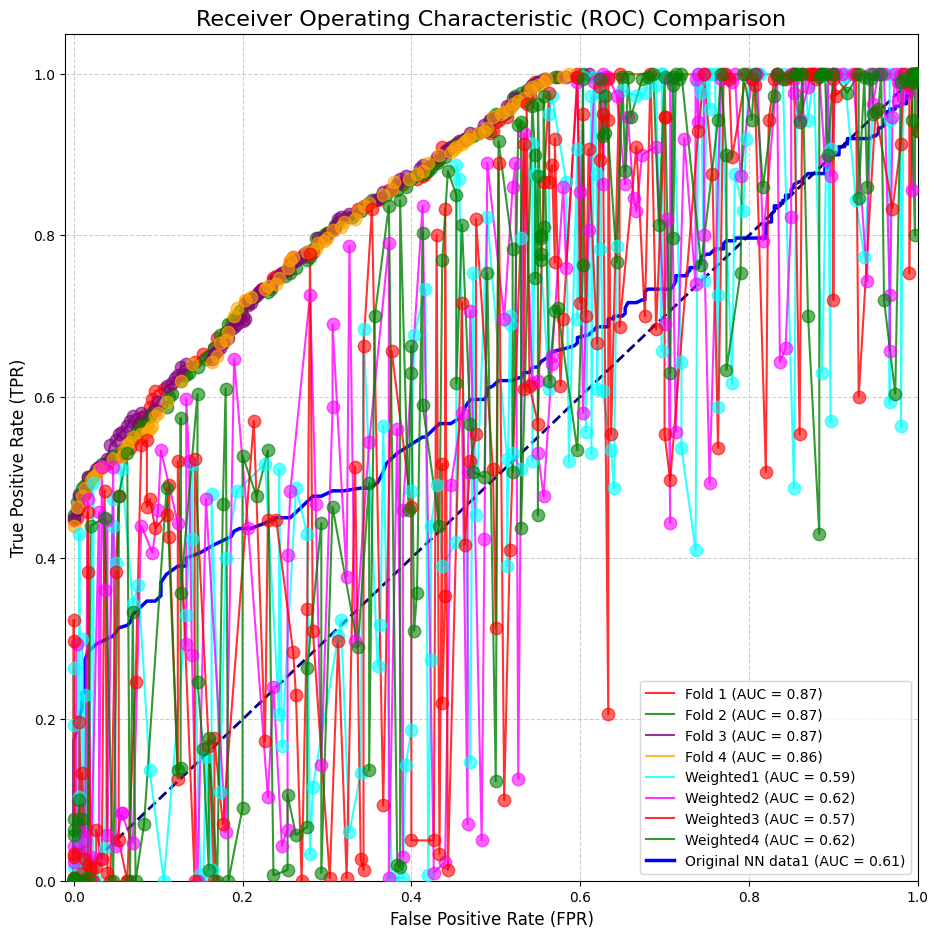

In [13]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4"],
    results_original_roc=results_original_roc
)

### Ensemble prediction using voting

In [14]:


# --- Loop through all the FPR values to generate the ensemble ROC curve ---

ensemble_results_soft = []
ensemble_results_hard = []

print("\n--- Generating Ensemble ROC Curve by iterating through FPR values ---")
# We iterate from a low to high target_fpr to trace the curve
for target_fpr in np.linspace(0.0, 1.0, 50): 
    # 1. Assign the function's output to a single variable first.
    result_tuple = predict_ensemble_and_evaluate(
        list_folds_best_models=list_folds_best_models,
        test_loader=test_loader,
        target_fpr=target_fpr
    )
    
    if result_tuple is not None:
        
        for voting_method, metrics in result_tuple.items():
            # Create a dictionary for each point and append it to the list
            if voting_method == 'soft_voting':
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_soft.append(point_dict)
            else:
                point_dict = {'fpr': metrics['fpr'], 'tpr': metrics['tpr']}
                ensemble_results_hard.append(point_dict)
            
        
# Ensure the curve starts at (0, 0)
    if not ensemble_results_soft or ensemble_results_soft[0]['fpr'] > 0.0:
        ensemble_results_soft.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_soft[-1]['fpr'] < 1.0 or ensemble_results_soft[-1]['tpr'] < 1.0:
        ensemble_results_soft.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    if not ensemble_results_hard or ensemble_results_hard[0]['fpr'] > 0.0:
        ensemble_results_hard.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if ensemble_results_hard[-1]['fpr'] < 1.0 or ensemble_results_hard[-1]['tpr'] < 1.0:
        ensemble_results_hard.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })







--- Generating Ensemble ROC Curve by iterating through FPR values ---
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0000
Soft Voting -> Achieved [TPR: 0.0000, FPR: 0.0000]
Hard Voting -> Resulted in [TPR: 0.4433, FPR: 0.0000]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0204
Soft Voting -> Achieved [TPR: 0.4900, FPR: 0.0167]
Hard Voting -> Resulted in [TPR: 0.4967, FPR: 0.0133]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0408
Soft Voting -> Achieved [TPR: 0.5067, FPR: 0.0400]
Hard Voting -> Resulted in [TPR: 0.5167, FPR: 0.0400]
Extracting full dataset from DataLoader for scikit-learn compatibility...
-> Extracted 600 samples.


--- Ensemble Results ---
Target FPR: 0.0612
Soft Voting -> Achieved [TPR: 


--- Plotting all ROC curves for comparison ---


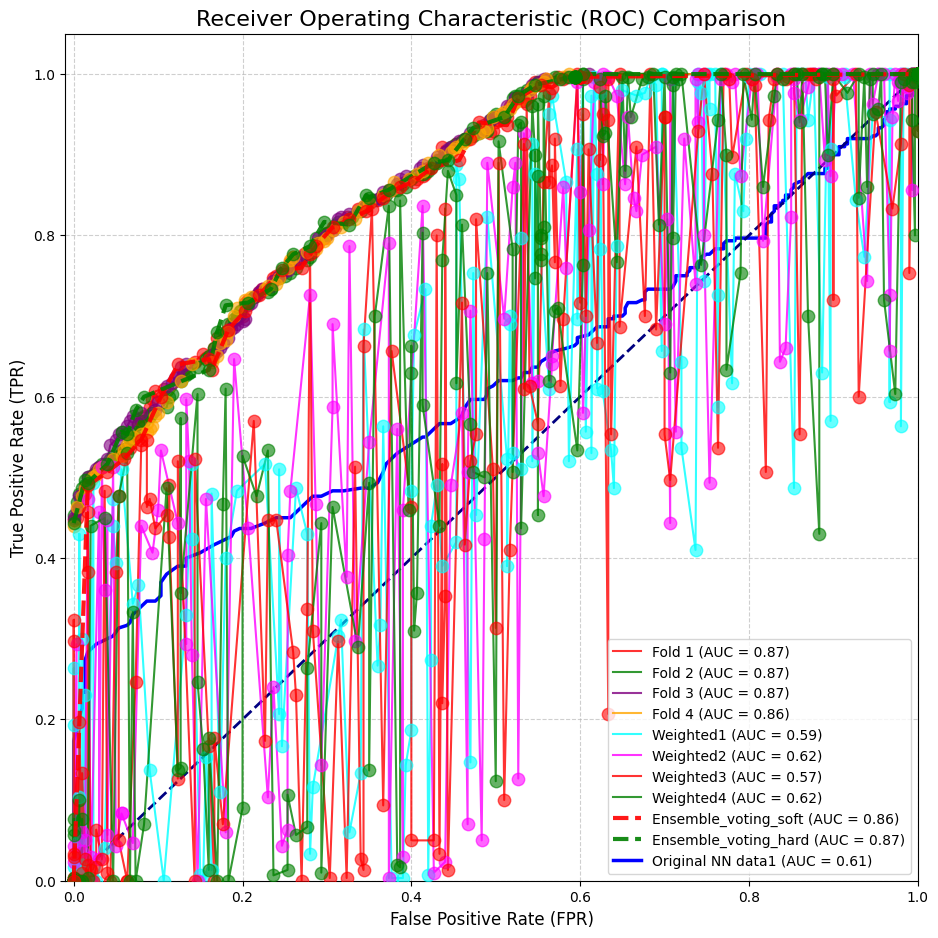

In [15]:
# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(ensemble_results_soft)
results_lists.append(ensemble_results_hard)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Ensemble_voting_soft", "Ensemble_voting_hard"],
    results_original_roc=results_original_roc
)

In [16]:
def roc_performance_tester(classifier_list, test_loader):

    list_weighted_clfs = []  # Reset the list for final testing
    for i, model_info in enumerate(classifier_list):
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}"),
            precision='16-mixed'
            )

        model = model_info["model"]
        raw_threshold = model_info["threshold"]


        # CORRECTED: Use isinstance() to check if model is a string
        if isinstance(model, str):
            print(f"Skipping model {i+1} as it is a string placeholder: '{model}'")
            continue

        # Check if the stored threshold is a NumPy number or a PyTorch Tensor
        if isinstance(raw_threshold, (np.number, torch.Tensor)):
            # If it is, we can safely call .item() to extract the Python float
            threshold = raw_threshold.item()
        else:
            # Otherwise, it's already a float or something that can be cast to one
            threshold = float(raw_threshold)
        model.current_test_threshold = threshold  # Set the threshold for this model

        # This code will now only run if 'model' is a PyTorch Lightning module
        # and not a string.
        print(f"--- Testing model {i+1} ---")

        trainer.test(model, dataloaders=test_loader, ckpt_path=None)
        
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)

    # Ensure the curve starts at (0, 0)
    if not list_weighted_clfs or list_weighted_clfs[0]['fpr'] > 0.0:
        list_weighted_clfs.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if list_weighted_clfs[-1]['fpr'] < 1.0 or list_weighted_clfs[-1]['tpr'] < 1.0:
        list_weighted_clfs.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return list_weighted_clfs